<a href="https://colab.research.google.com/github/Shrv03/Path_planning_model_SDC/blob/main/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install opencv-python-headless
!pip install ultralytics  # For YOLO
!pip install filterpy  # For Kalman filters
!pip install matplotlib
!pip install numpy
!pip install torch torchvision
!pip install scikit-image

# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import torchvision
from ultralytics import YOLO
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import heapq
from collections import deque
import time
from google.colab.patches import cv2_imshow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [4]:
# Download sample driving video or images
!wget -q https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip
!unzip -q coco128.zip

# Alternative: Use sample video
!wget -q https://github.com/intel-iot-devkit/sample-videos/raw/master/car-detection.mp4 -O sample_video.mp4

replace coco128/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000612.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000404.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000438.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000389.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000564.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000149.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000605.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000349.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000201.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/train2017/000000000599.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace coco128/images/tr

In [5]:
class PerceptionModule:
    def __init__(self):
        # Load pre-trained YOLO model
        self.model = YOLO('yolov8n.pt')  # or yolov8s.pt for better accuracy
        self.classes_of_interest = [0, 1, 2, 3, 5, 7]  # person, bicycle, car, motorcycle, bus, truck

    def detect_objects(self, frame):
        """Detect objects in a frame"""
        results = self.model(frame)

        detections = []
        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    cls = int(box.cls)
                    if cls in self.classes_of_interest:
                        x1, y1, x2, y2 = box.xyxy[0].tolist()
                        conf = box.conf[0].item()
                        detections.append({
                            'bbox': [x1, y1, x2, y2],
                            'class': cls,
                            'confidence': conf,
                            'center': [(x1+x2)/2, (y1+y2)/2]
                        })
        return detections

    def detect_lanes(self, frame):
        """Simple lane detection using edge detection and Hough transform"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)

        # Region of interest (lower half of image)
        height, width = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (0, height),
            (width, height),
            (width, int(height*0.6)),
            (0, int(height*0.6))
        ]], np.int32)
        cv2.fillPoly(mask, polygon, 255)
        masked_edges = cv2.bitwise_and(edges, mask)

        # Detect lines
        lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180, 50,
                               minLineLength=100, maxLineGap=50)

        lane_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                lane_lines.append([(x1, y1), (x2, y2)])

        return lane_lines

In [6]:
def create_occupancy_grid(detections, frame_shape, grid_size=(50, 50)):
    """Convert detections to occupancy grid for path planning"""
    h, w = frame_shape[:2]
    grid_h, grid_w = grid_size
    cell_h, cell_w = h // grid_h, w // grid_w

    occupancy_grid = np.zeros(grid_size)

    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        # Convert to grid coordinates
        grid_x1 = int(x1 // cell_w)
        grid_y1 = int(y1 // cell_h)
        grid_x2 = int(x2 // cell_w)
        grid_y2 = int(y2 // cell_h)

        # Mark occupied cells
        occupancy_grid[grid_y1:grid_y2+1, grid_x1:grid_x2+1] = 1

    return occupancy_grid

In [7]:
class PredictionModule:
    def __init__(self):
        self.trackers = {}
        self.next_id = 0

    def create_kalman_filter(self):
        """Create a Kalman filter for 2D position and velocity tracking"""
        kf = KalmanFilter(dim_x=4, dim_z=2)

        # State transition matrix (position and velocity)
        kf.F = np.array([[1, 0, 1, 0],  # x = x + vx*dt
                         [0, 1, 0, 1],  # y = y + vy*dt
                         [0, 0, 1, 0],  # vx = vx
                         [0, 0, 0, 1]]) # vy = vy

        # Measurement matrix (we observe x, y)
        kf.H = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0]])

        # Measurement noise
        kf.R = np.array([[10, 0],
                         [0, 10]])

        # Process noise
        kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=0.1, block_size=2)

        # Initial uncertainty
        kf.P *= 100

        return kf

    def update_trackers(self, detections):
        """Update Kalman filters with new detections"""
        # Simple nearest neighbor association
        matched = []
        for det in detections:
            center = det['center']
            min_dist = float('inf')
            matched_id = None

            for track_id, tracker in self.trackers.items():
                pred_pos = tracker['kf'].x[:2]
                dist = np.linalg.norm(np.array(center) - pred_pos)
                if dist < min_dist and dist < 50:  # threshold
                    min_dist = dist
                    matched_id = track_id

            if matched_id is not None:
                self.trackers[matched_id]['kf'].update(center)
                self.trackers[matched_id]['last_update'] = time.time()
                matched.append(matched_id)
            else:
                # Create new tracker
                kf = self.create_kalman_filter()
                kf.x[:2] = center
                self.trackers[self.next_id] = {
                    'kf': kf,
                    'last_update': time.time()
                }
                self.next_id += 1

        # Remove old trackers
        current_time = time.time()
        to_remove = []
        for track_id, tracker in self.trackers.items():
            if current_time - tracker['last_update'] > 2.0:  # 2 seconds timeout
                to_remove.append(track_id)

        for track_id in to_remove:
            del self.trackers[track_id]

    def predict_positions(self, time_horizon=2.0, dt=0.1):
        """Predict future positions of tracked objects"""
        predictions = {}
        steps = int(time_horizon / dt)

        for track_id, tracker in self.trackers.items():
            kf = tracker['kf']
            predictions[track_id] = []

            # Save current state
            saved_x = kf.x.copy()
            saved_P = kf.P.copy()

            # Predict future positions
            for _ in range(steps):
                kf.predict()
                predictions[track_id].append(kf.x[:2].copy())

            # Restore state
            kf.x = saved_x
            kf.P = saved_P

        return predictions

In [8]:
class PlanningModule:
    def __init__(self, grid_size=(50, 50)):
        self.grid_size = grid_size

    def heuristic(self, a, b):
        """Manhattan distance heuristic"""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def get_neighbors(self, node, occupancy_grid):
        """Get valid neighbors for A* search"""
        neighbors = []
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0),
                       (1, 1), (-1, 1), (1, -1), (-1, -1)]:
            new_x, new_y = node[0] + dx, node[1] + dy
            if (0 <= new_x < self.grid_size[0] and
                0 <= new_y < self.grid_size[1] and
                occupancy_grid[new_y, new_x] == 0):
                neighbors.append((new_x, new_y))
        return neighbors

    def a_star(self, start, goal, occupancy_grid):
        """A* path planning algorithm"""
        open_set = []
        heapq.heappush(open_set, (0, start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: self.heuristic(start, goal)}

        while open_set:
            current = heapq.heappop(open_set)[1]

            if current == goal:
                # Reconstruct path
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                return path[::-1]

            for neighbor in self.get_neighbors(current, occupancy_grid):
                tentative_g_score = g_score[current] + 1

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        return []  # No path found

    def smooth_path(self, path, occupancy_grid):
        """Simple path smoothing"""
        if len(path) < 3:
            return path

        smoothed = [path[0]]
        i = 0

        while i < len(path) - 1:
            j = len(path) - 1
            while j > i + 1:
                if self.line_of_sight(path[i], path[j], occupancy_grid):
                    smoothed.append(path[j])
                    i = j
                    break
                j -= 1
            else:
                i += 1
                if i < len(path):
                    smoothed.append(path[i])

        return smoothed

    def line_of_sight(self, p1, p2, occupancy_grid):
        """Check if there's a clear line of sight between two points"""
        x1, y1 = p1
        x2, y2 = p2

        # Bresenham's line algorithm
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy

        while True:
            if occupancy_grid[y1, x1] == 1:
                return False

            if x1 == x2 and y1 == y2:
                break

            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy

        return True

In [9]:
class ControlModule:
    def __init__(self):
        # PID gains
        self.kp_steering = 0.5
        self.ki_steering = 0.0
        self.kd_steering = 0.1

        self.kp_throttle = 0.3
        self.ki_throttle = 0.0
        self.kd_throttle = 0.05

        # Error tracking
        self.prev_steering_error = 0
        self.integral_steering_error = 0

        self.prev_throttle_error = 0
        self.integral_throttle_error = 0

    def compute_control(self, current_pos, target_pos, current_heading=0):
        """Compute steering and throttle commands"""
        # Calculate errors
        dx = target_pos[0] - current_pos[0]
        dy = target_pos[1] - current_pos[1]

        # Desired heading
        desired_heading = np.arctan2(dy, dx)

        # Steering error (normalize to [-pi, pi])
        steering_error = desired_heading - current_heading
        steering_error = np.arctan2(np.sin(steering_error), np.cos(steering_error))

        # PID for steering
        self.integral_steering_error += steering_error
        derivative_steering_error = steering_error - self.prev_steering_error

        steering_cmd = (self.kp_steering * steering_error +
                       self.ki_steering * self.integral_steering_error +
                       self.kd_steering * derivative_steering_error)

        self.prev_steering_error = steering_error

        # Distance error for throttle
        distance_error = np.sqrt(dx**2 + dy**2)

        # PID for throttle
        self.integral_throttle_error += distance_error
        derivative_throttle_error = distance_error - self.prev_throttle_error

        throttle_cmd = (self.kp_throttle * distance_error +
                       self.ki_throttle * self.integral_throttle_error +
                       self.kd_throttle * derivative_throttle_error)

        self.prev_throttle_error = distance_error

        # Clamp commands
        steering_cmd = np.clip(steering_cmd, -1.0, 1.0)
        throttle_cmd = np.clip(throttle_cmd, 0.0, 1.0)

        return steering_cmd, throttle_cmd

In [10]:
class AVPipeline:
    def __init__(self):
        self.perception = PerceptionModule()
        self.prediction = PredictionModule()
        self.planning = PlanningModule()
        self.control = ControlModule()

        # Vehicle state
        self.vehicle_pos = (25, 40)  # Grid coordinates
        self.vehicle_heading = 0
        self.path = []

    def process_frame(self, frame):
        """Process a single frame through the entire pipeline"""
        # 1. Perception
        detections = self.perception.detect_objects(frame)
        lanes = self.perception.detect_lanes(frame)
        occupancy_grid = create_occupancy_grid(detections, frame.shape)

        # 2. Prediction
        self.prediction.update_trackers(detections)
        predictions = self.prediction.predict_positions()

        # 3. Planning
        goal = (25, 5)  # Example goal
        if len(self.path) == 0 or np.random.random() < 0.1:  # Replan occasionally
            self.path = self.planning.a_star(self.vehicle_pos, goal, occupancy_grid)
            if self.path:
                self.path = self.planning.smooth_path(self.path, occupancy_grid)

        # 4. Control
        if len(self.path) > 1:
            target = self.path[1]  # Next waypoint
            steering, throttle = self.control.compute_control(
                self.vehicle_pos, target, self.vehicle_heading
            )

            # Update vehicle position (simplified dynamics)
            dx = throttle * np.cos(self.vehicle_heading)
            dy = throttle * np.sin(self.vehicle_heading)
            new_x = self.vehicle_pos[0] + dx * 0.5
            new_y = self.vehicle_pos[1] + dy * 0.5

            # Check if new position is valid
            if (0 <= int(new_x) < 50 and 0 <= int(new_y) < 50 and
                occupancy_grid[int(new_y), int(new_x)] == 0):
                self.vehicle_pos = (new_x, new_y)
                self.vehicle_heading += steering * 0.1

            # Remove reached waypoints
            if np.linalg.norm(np.array(self.vehicle_pos) - np.array(target)) < 2:
                self.path.pop(0)
        else:
            steering, throttle = 0, 0

        return {
            'detections': detections,
            'lanes': lanes,
            'occupancy_grid': occupancy_grid,
            'predictions': predictions,
            'path': self.path,
            'steering': steering,
            'throttle': throttle
        }

    def visualize_results(self, frame, results):
        """Visualize all components"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Object detection and lanes
        ax1 = axes[0, 0]
        ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        for det in results['detections']:
            x1, y1, x2, y2 = det['bbox']
            rect = Rectangle((x1, y1), x2-x1, y2-y1,
                           linewidth=2, edgecolor='r', facecolor='none')
            ax1.add_patch(rect)

        for line in results['lanes']:
            (x1, y1), (x2, y2) = line
            ax1.plot([x1, x2], [y1, y2], 'g-', linewidth=2)

        ax1.set_title('Perception: Objects & Lanes')
        ax1.axis('off')

        # 2. Occupancy grid and path
        ax2 = axes[0, 1]
        ax2.imshow(results['occupancy_grid'], cmap='binary', origin='lower')

        if results['path']:
            path_array = np.array(results['path'])
            ax2.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=2)
            ax2.plot(path_array[:, 0], path_array[:, 1], 'bo', markersize=5)

        # Vehicle position
        ax2.plot(self.vehicle_pos[0], self.vehicle_pos[1], 'go', markersize=10)

        ax2.set_title('Planning: Occupancy Grid & Path')
        ax2.grid(True, alpha=0.3)

        # 3. Predictions
        ax3 = axes[1, 0]
        ax3.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), alpha=0.5)

        # Convert grid predictions back to image coordinates
        h, w = frame.shape[:2]
        for track_id, pred_positions in results['predictions'].items():
            if pred_positions:
                pred_array = np.array(pred_positions)
                # Scale from grid to image coordinates
                pred_array[:, 0] *= w / 50
                pred_array[:, 1] *= h / 50
                ax3.plot(pred_array[:, 0], pred_array[:, 1], 'r--', linewidth=2)

        ax3.set_title('Prediction: Future Trajectories')
        ax3.axis('off')

        # 4. Control signals
        ax4 = axes[1, 1]
        ax4.bar(['Steering', 'Throttle'],
                [results['steering'], results['throttle']],
                color=['blue', 'green'])
        ax4.set_ylim(-1, 1)
        ax4.set_title('Control: Command Outputs')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

100%|██████████| 6.25M/6.25M [00:00<00:00, 114MB/s]



0: 384x640 (no detections), 49.0ms
Speed: 15.8ms preprocess, 49.0ms inference, 104.5ms postprocess per image at shape (1, 3, 384, 640)


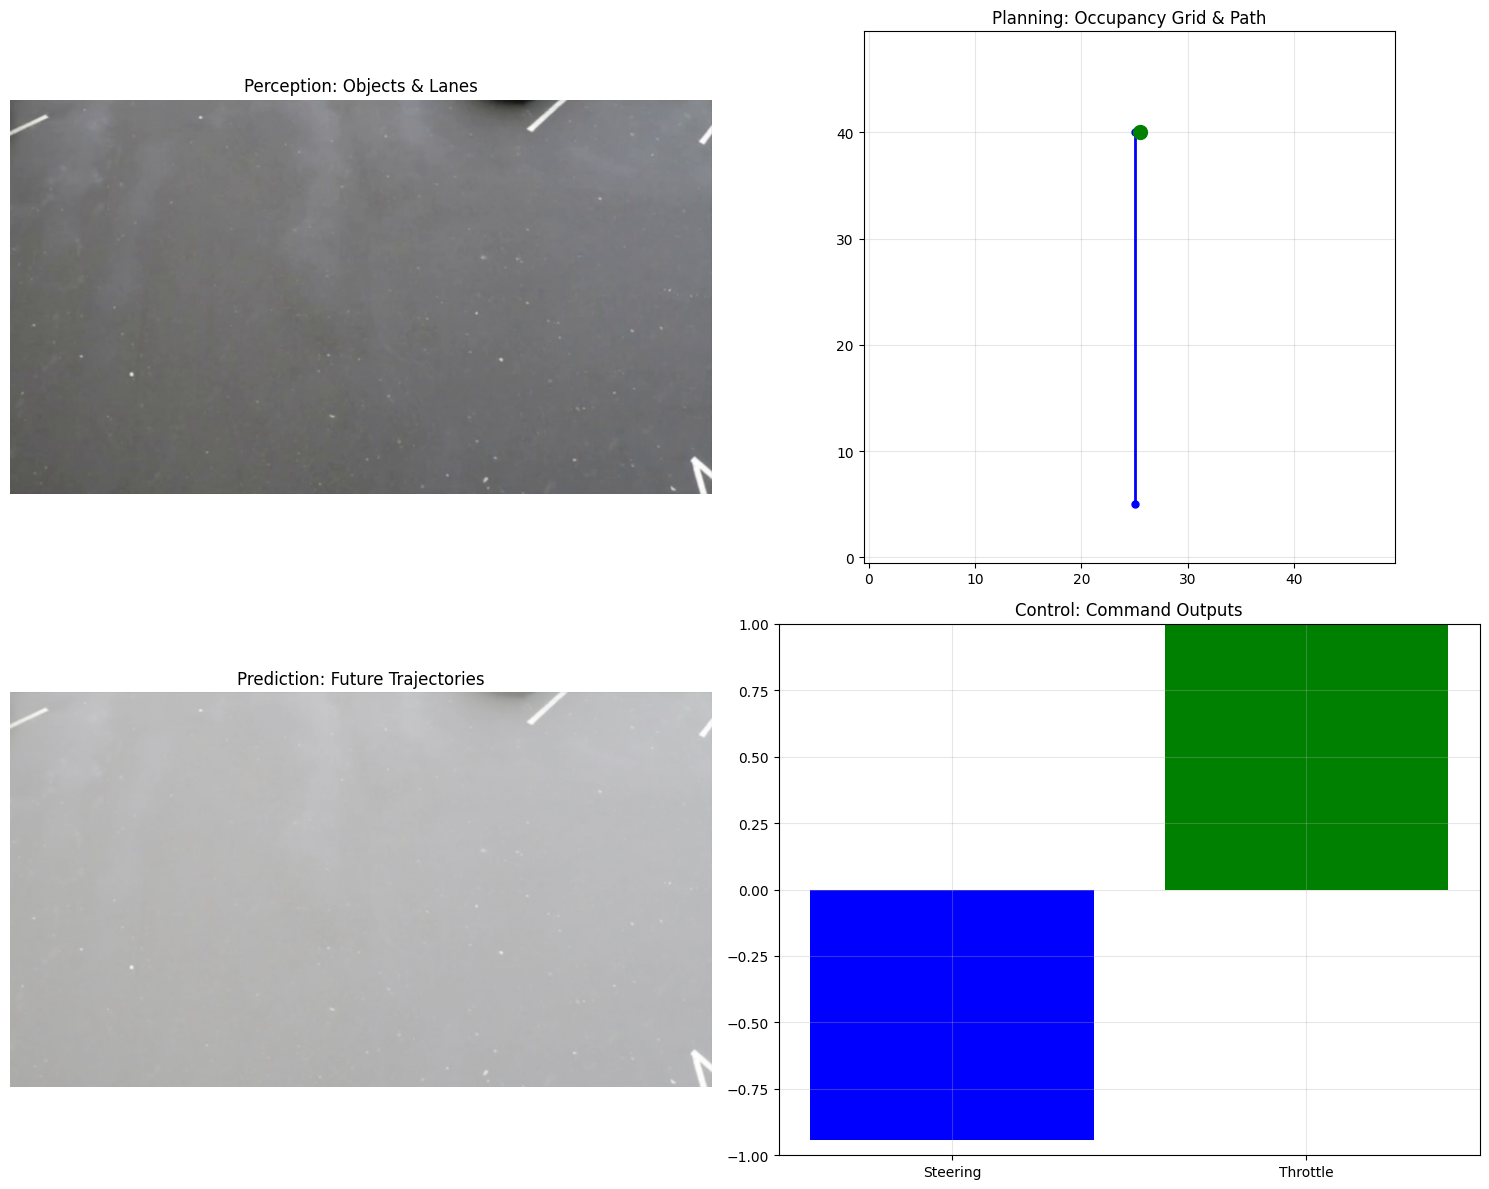


0: 384x640 (no detections), 13.4ms
Speed: 3.7ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


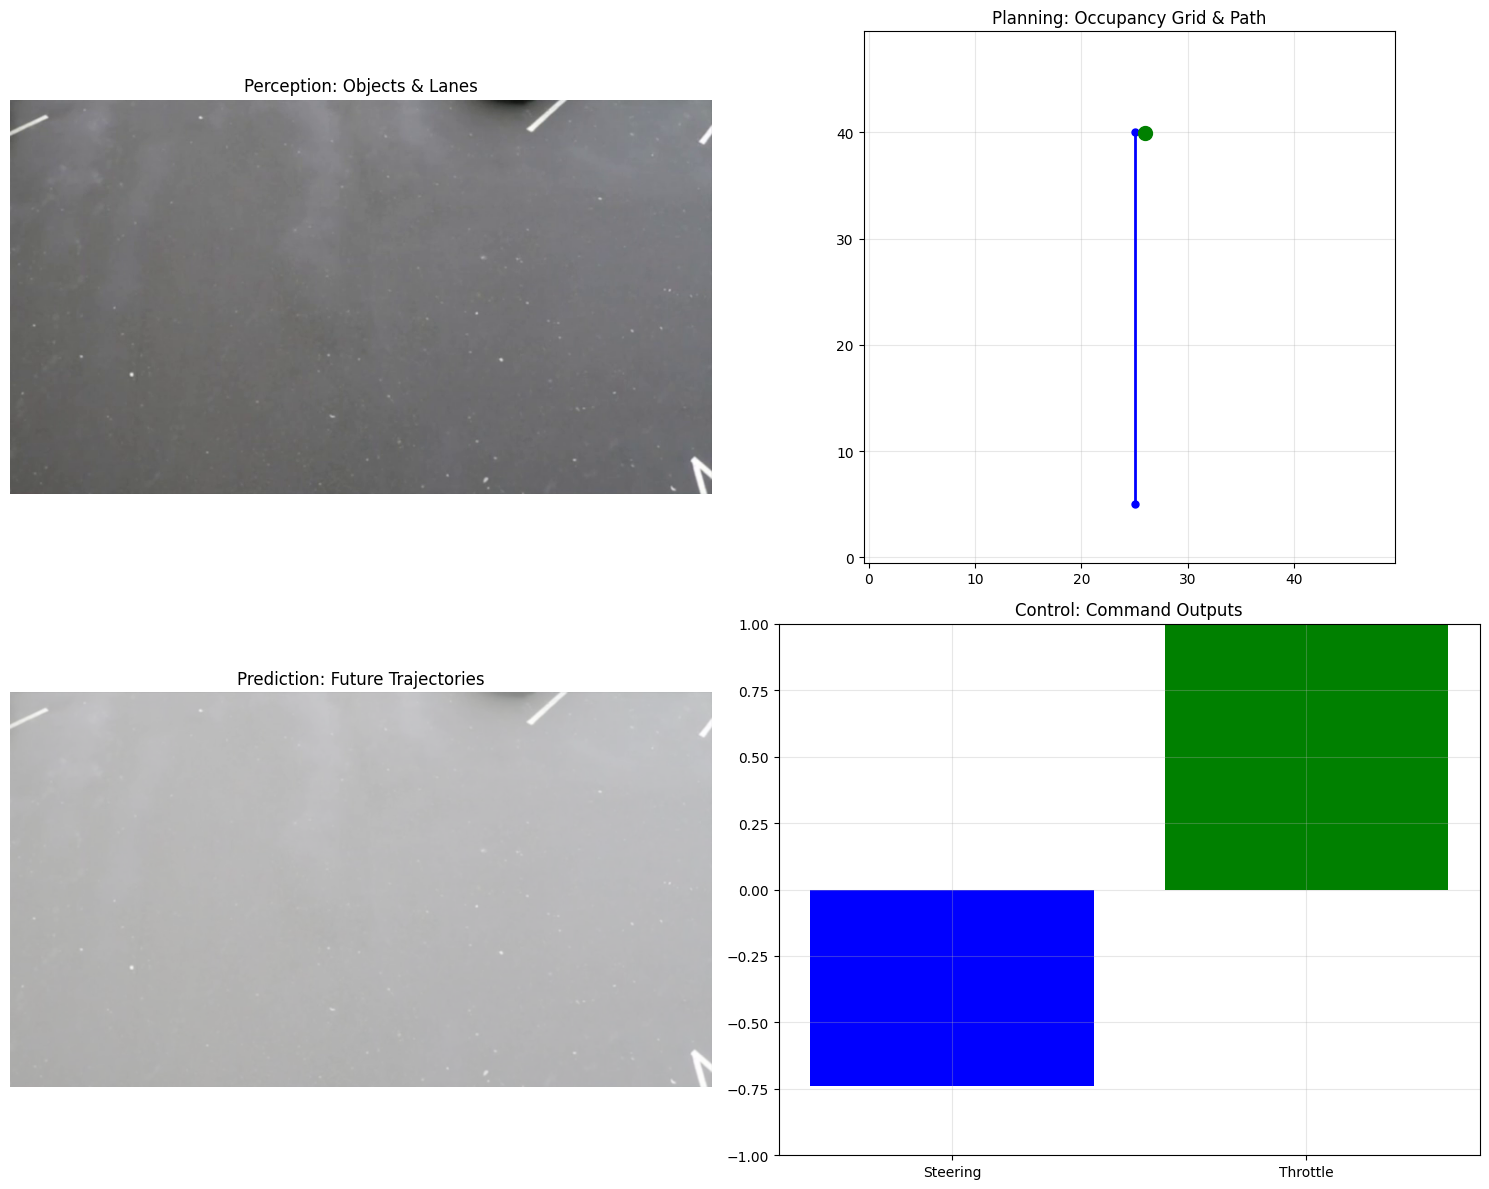


0: 384x640 (no detections), 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


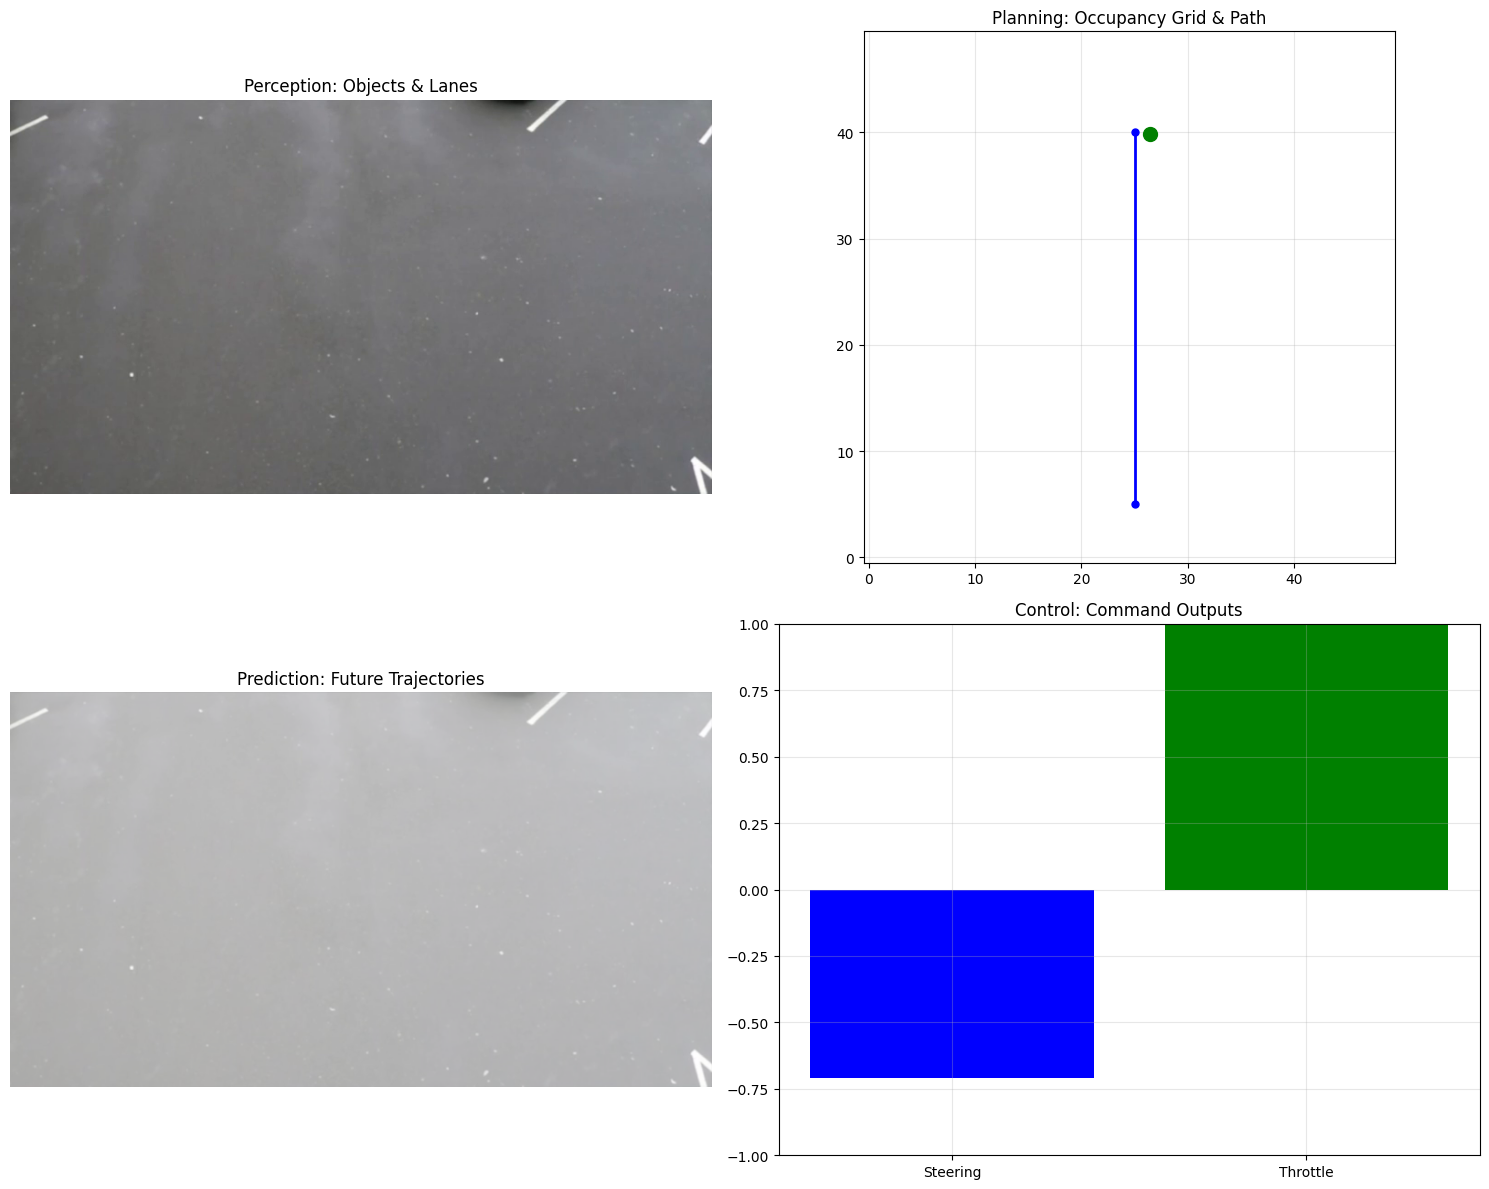


0: 384x640 (no detections), 11.8ms
Speed: 3.7ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


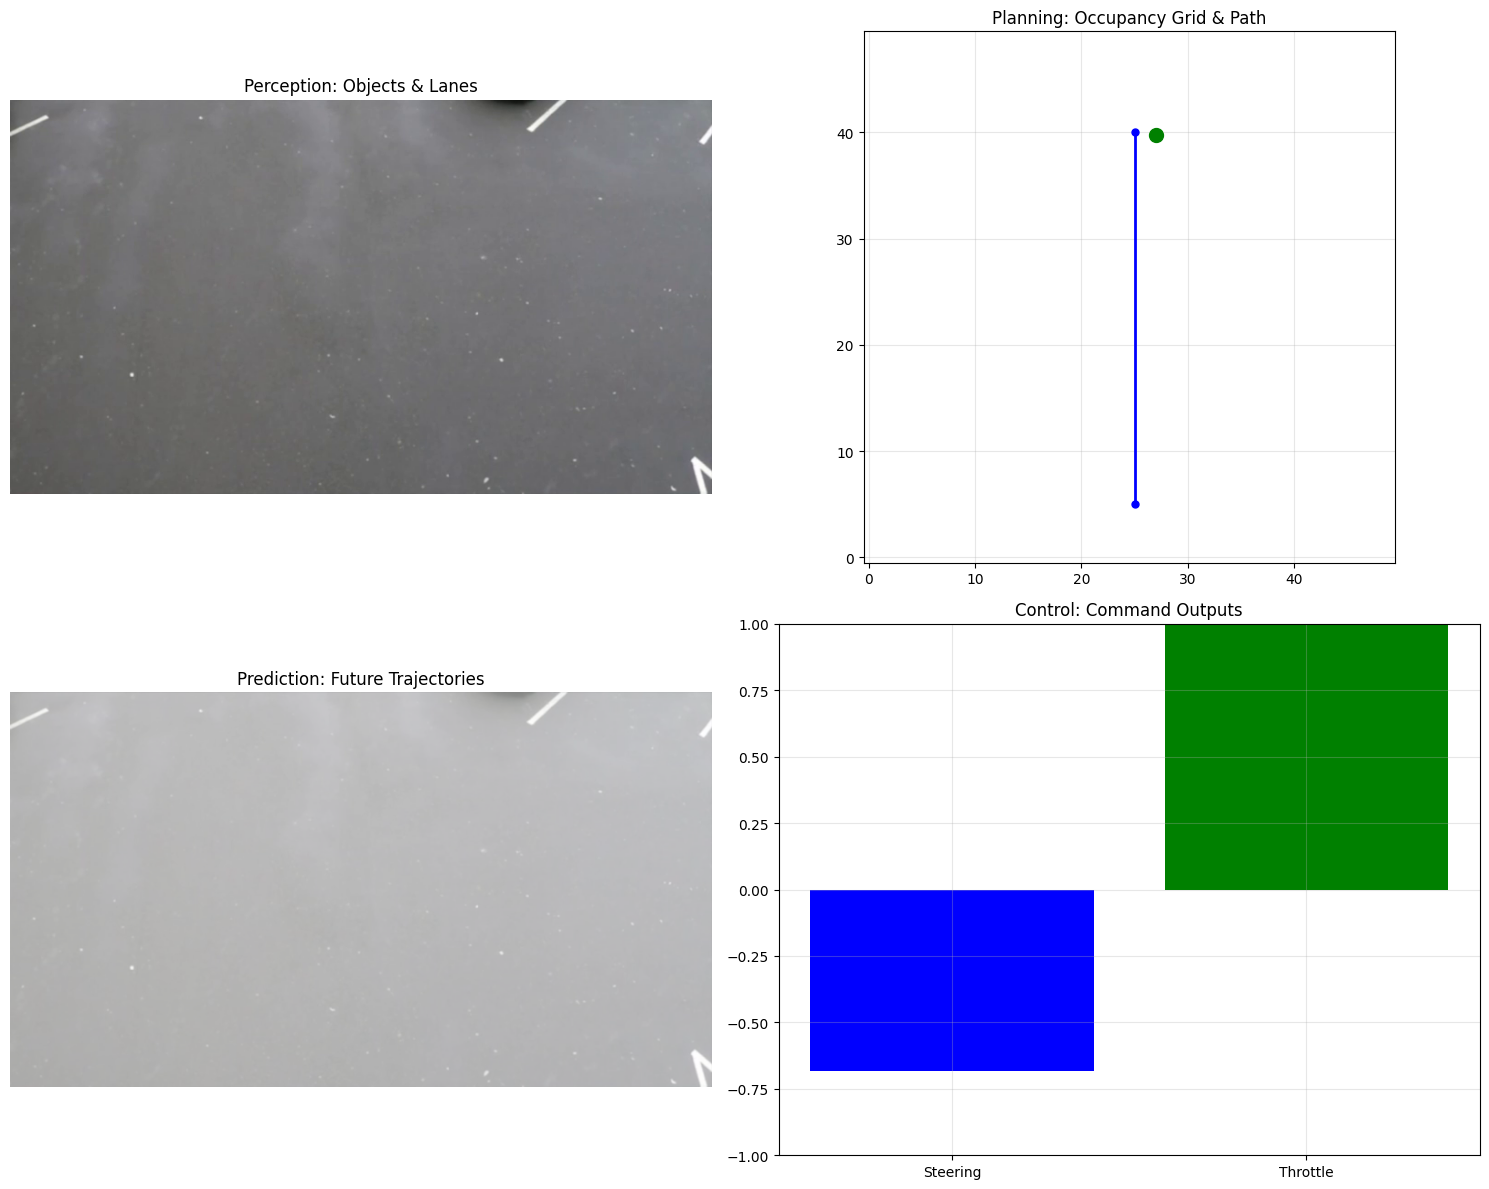


0: 384x640 (no detections), 14.6ms
Speed: 2.9ms preprocess, 14.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


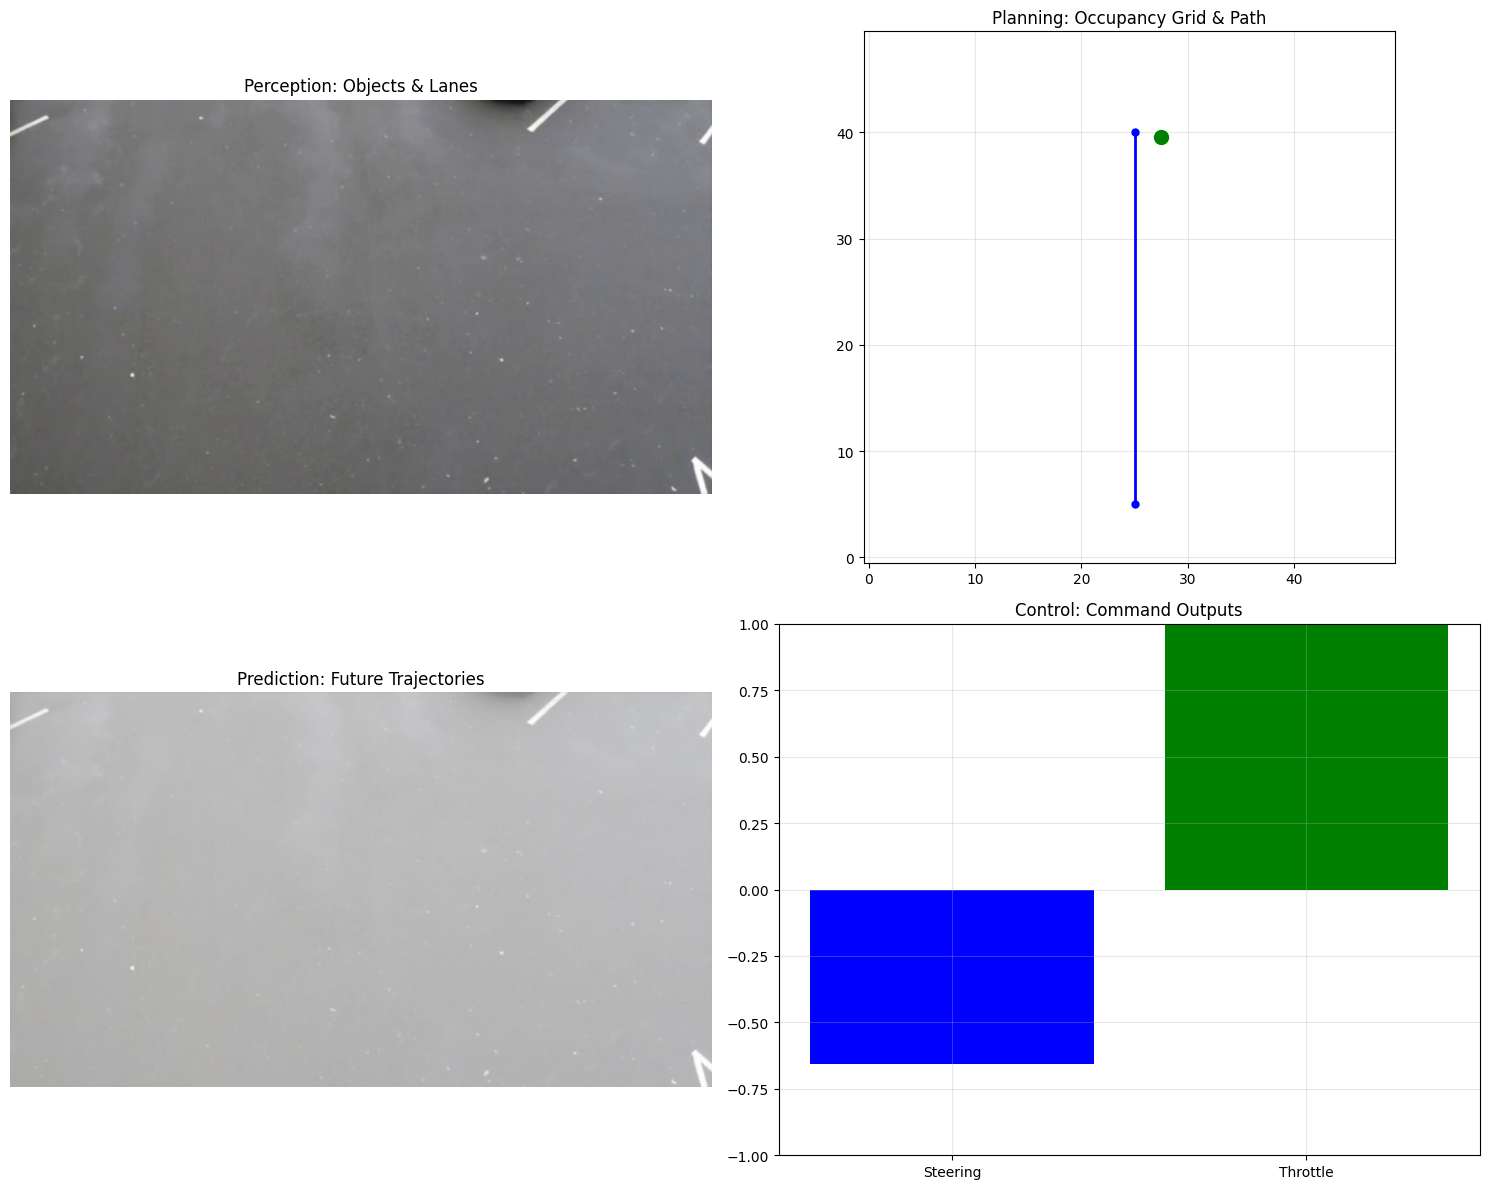


0: 384x640 (no detections), 11.4ms
Speed: 3.6ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


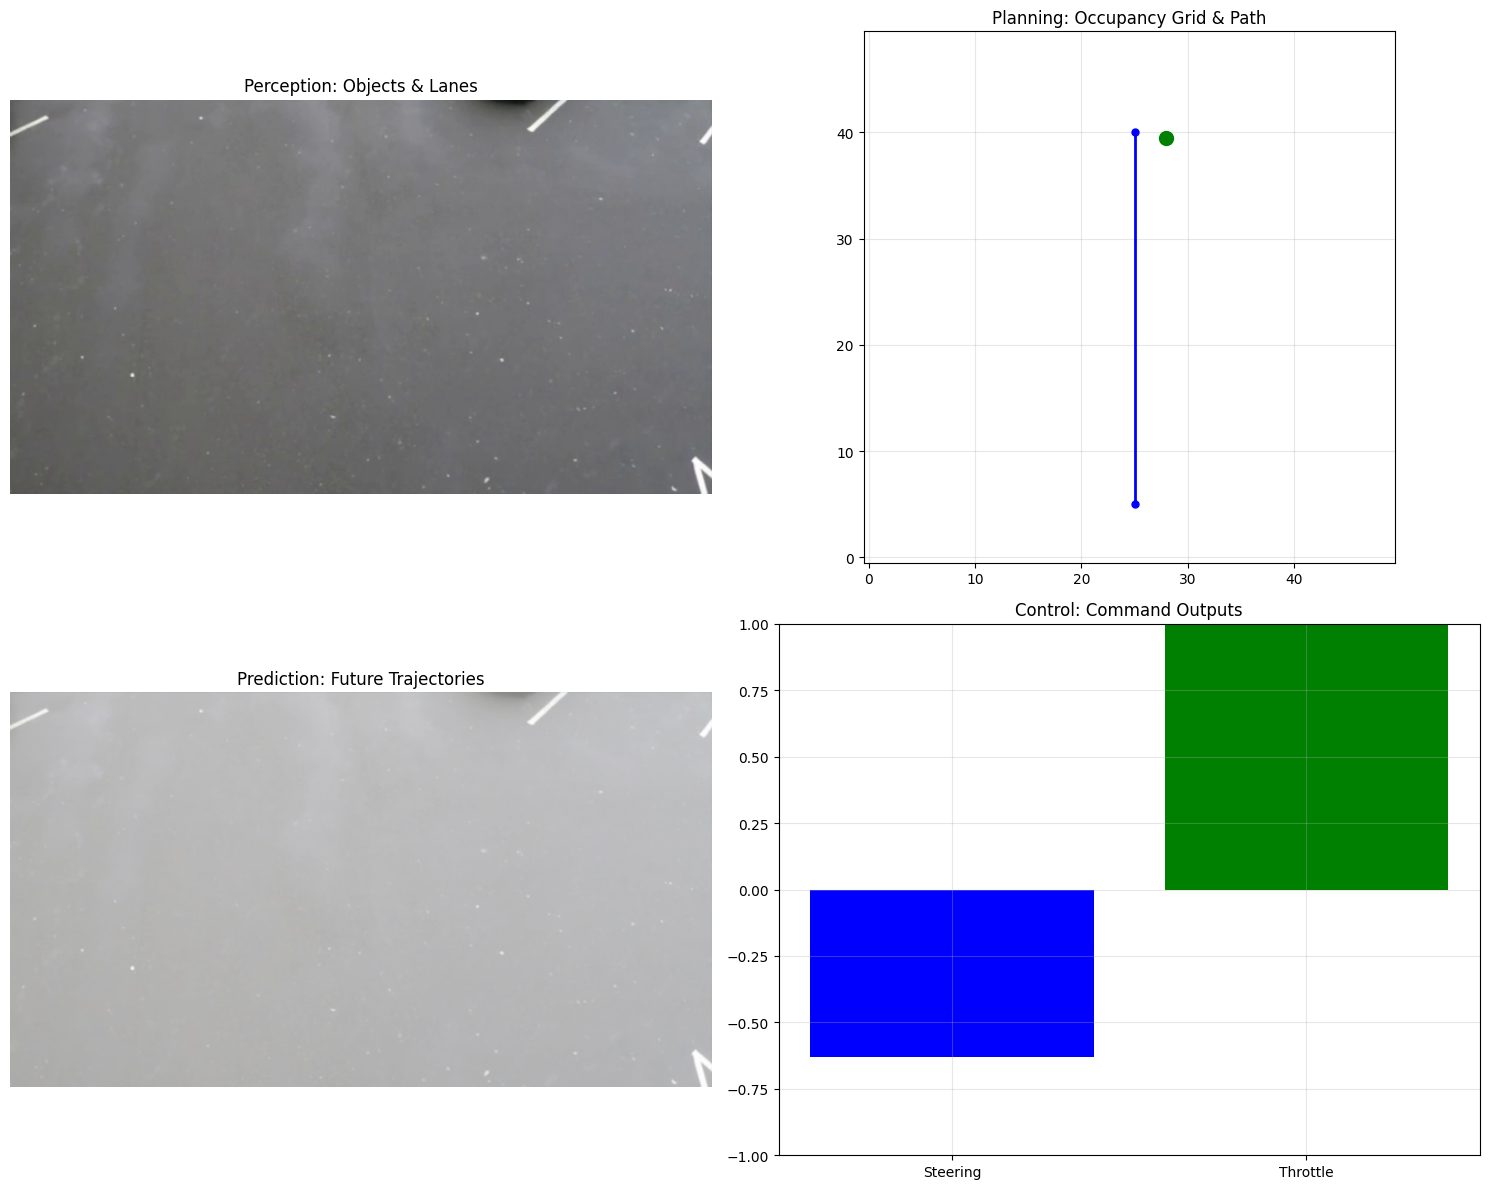


0: 384x640 (no detections), 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


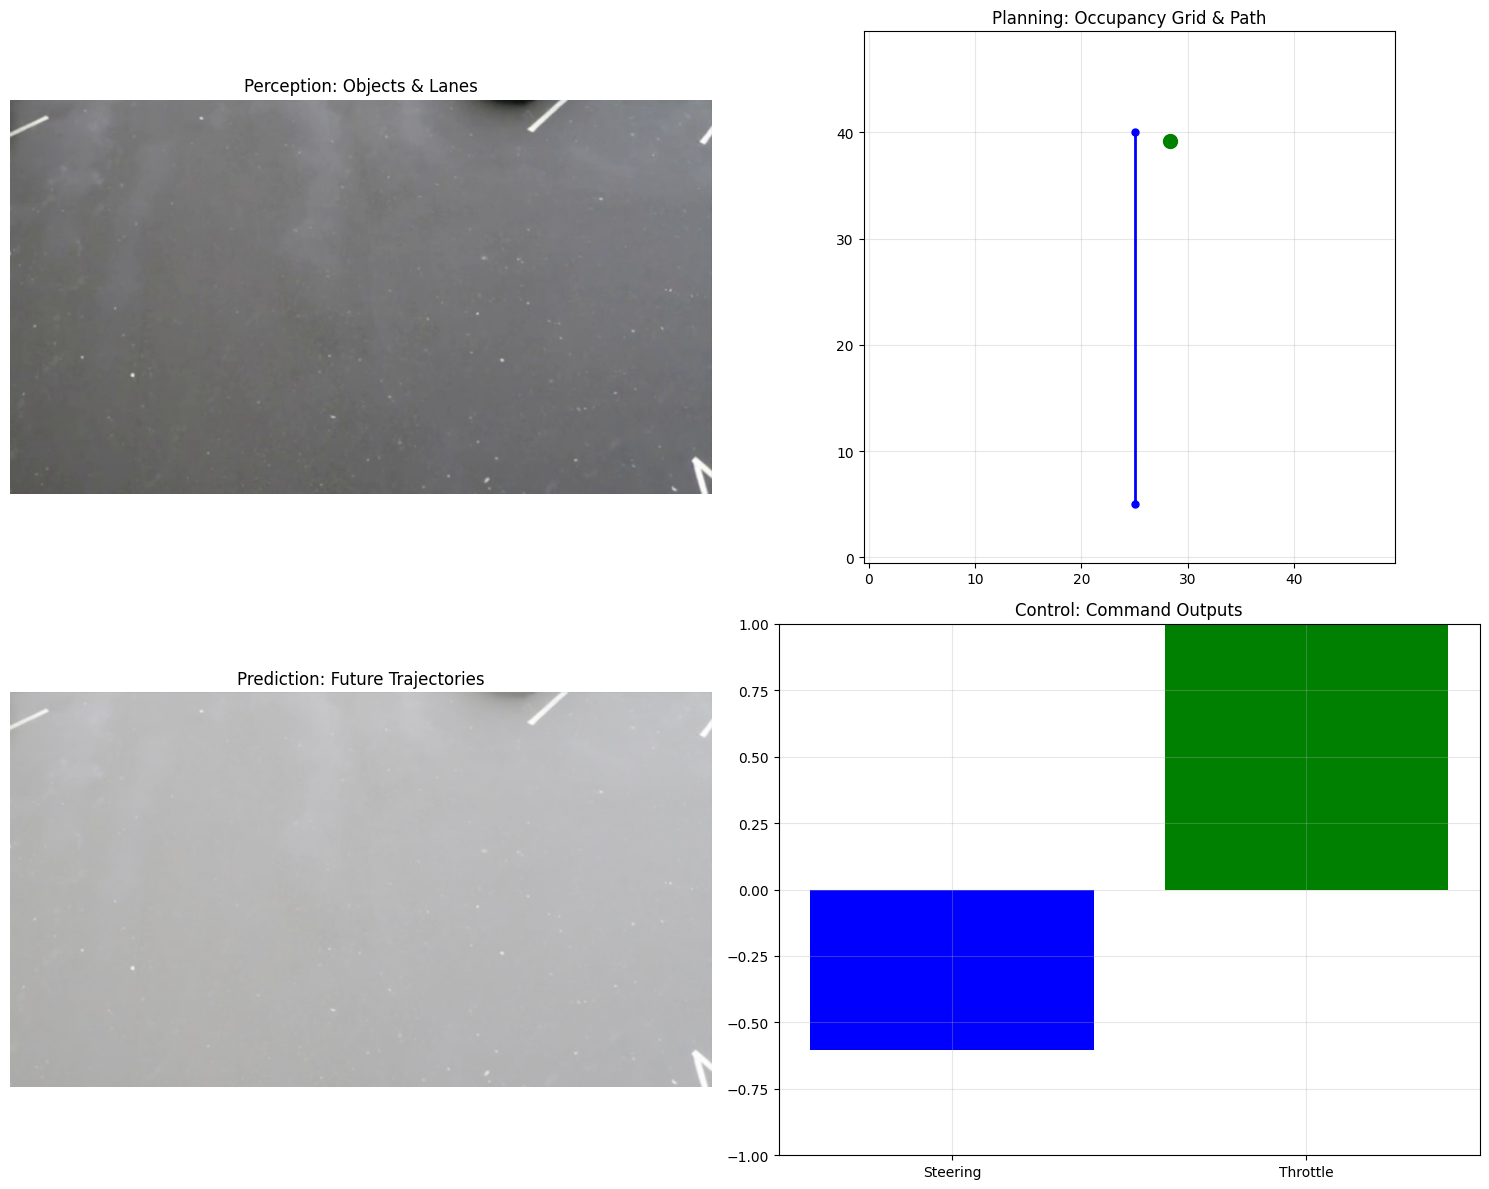


0: 384x640 (no detections), 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


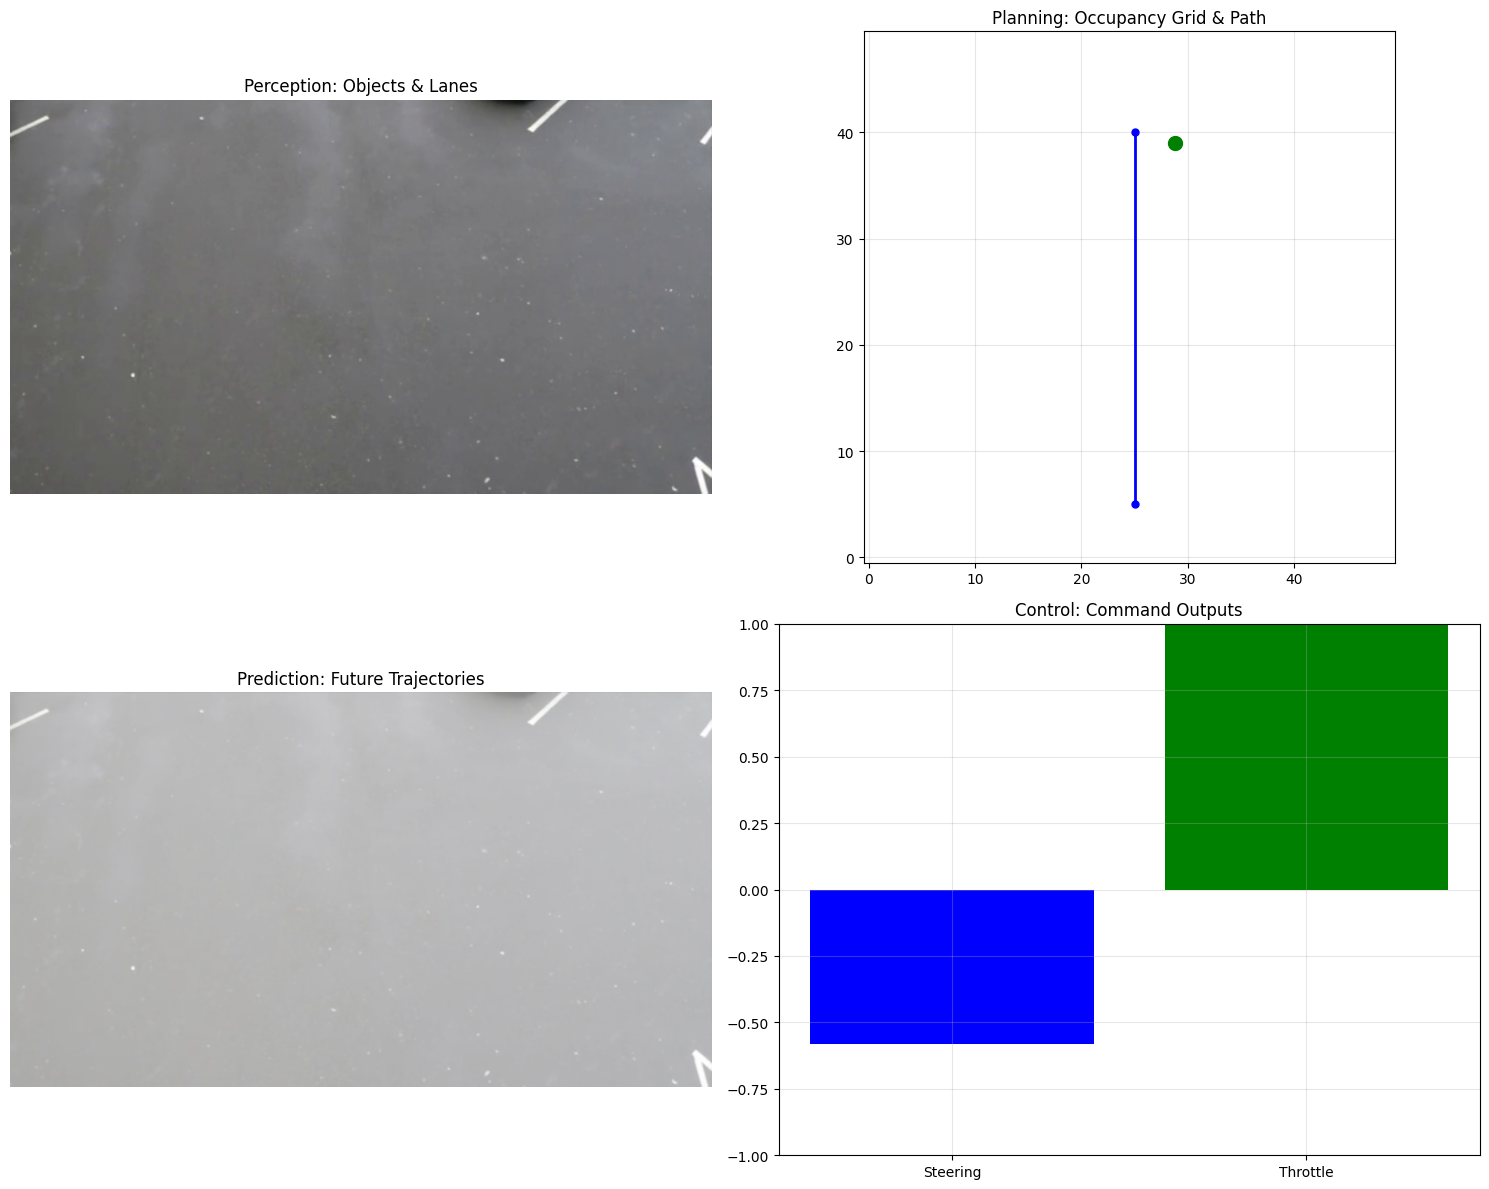


0: 384x640 (no detections), 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


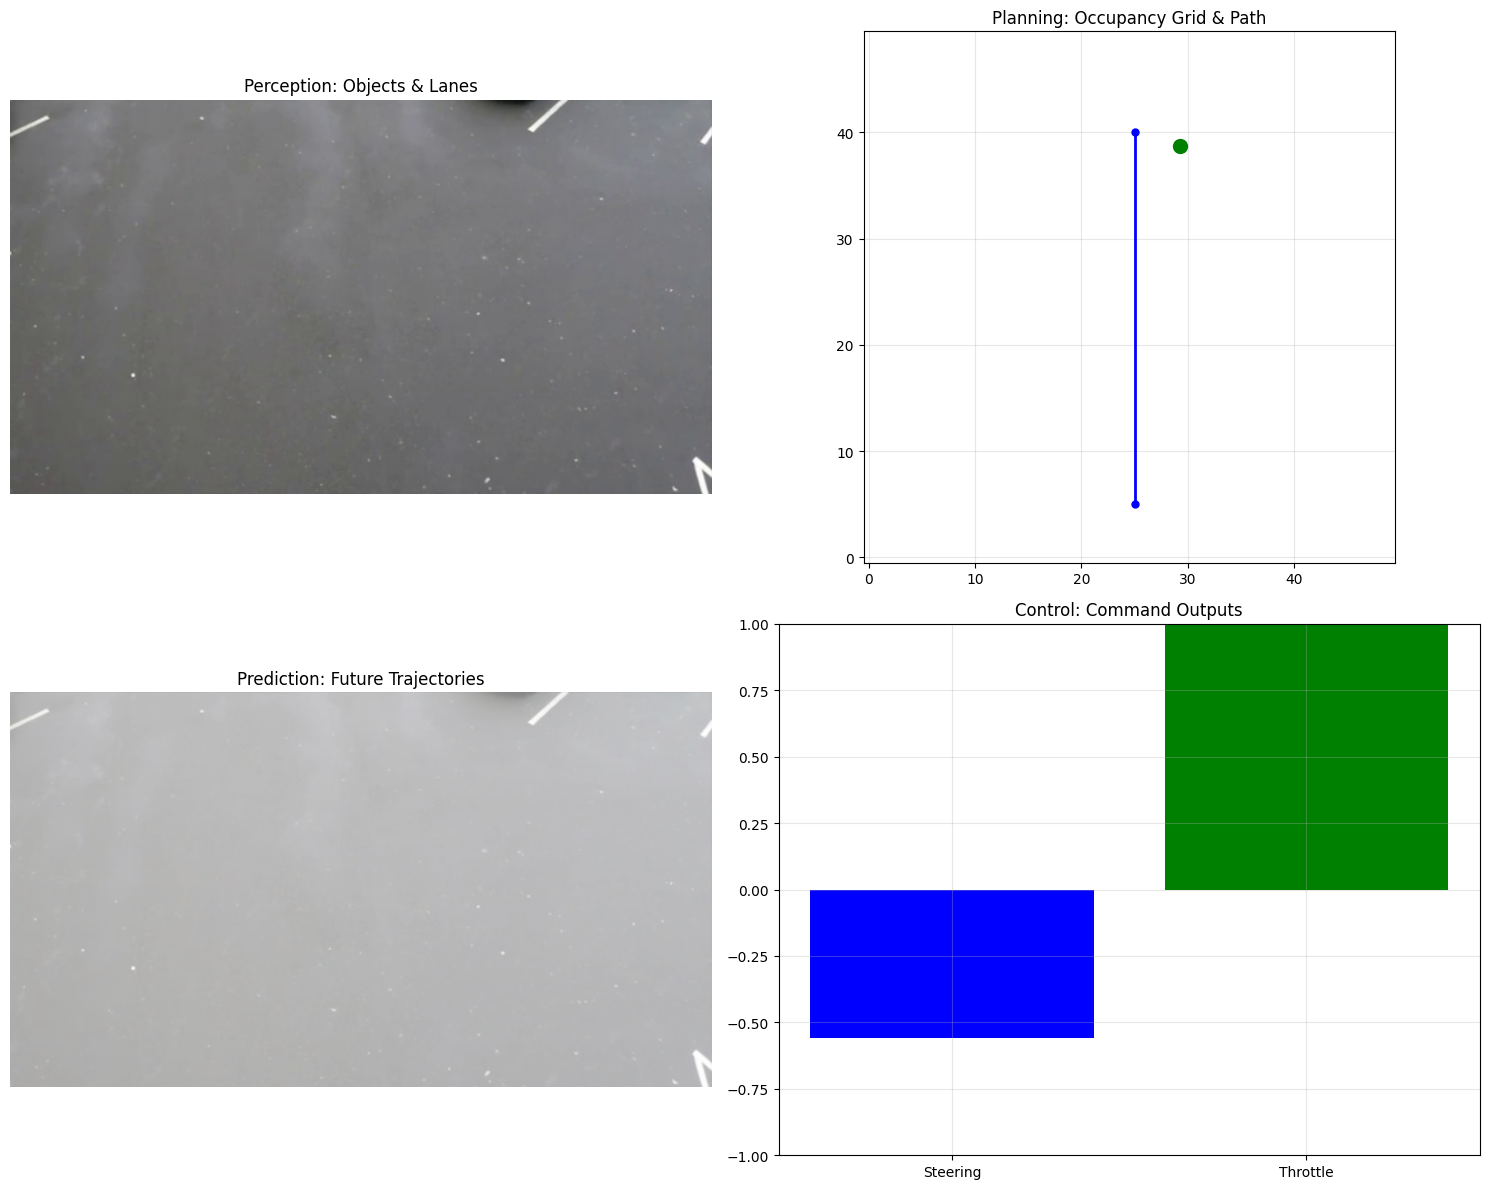


0: 384x640 (no detections), 13.6ms
Speed: 3.1ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


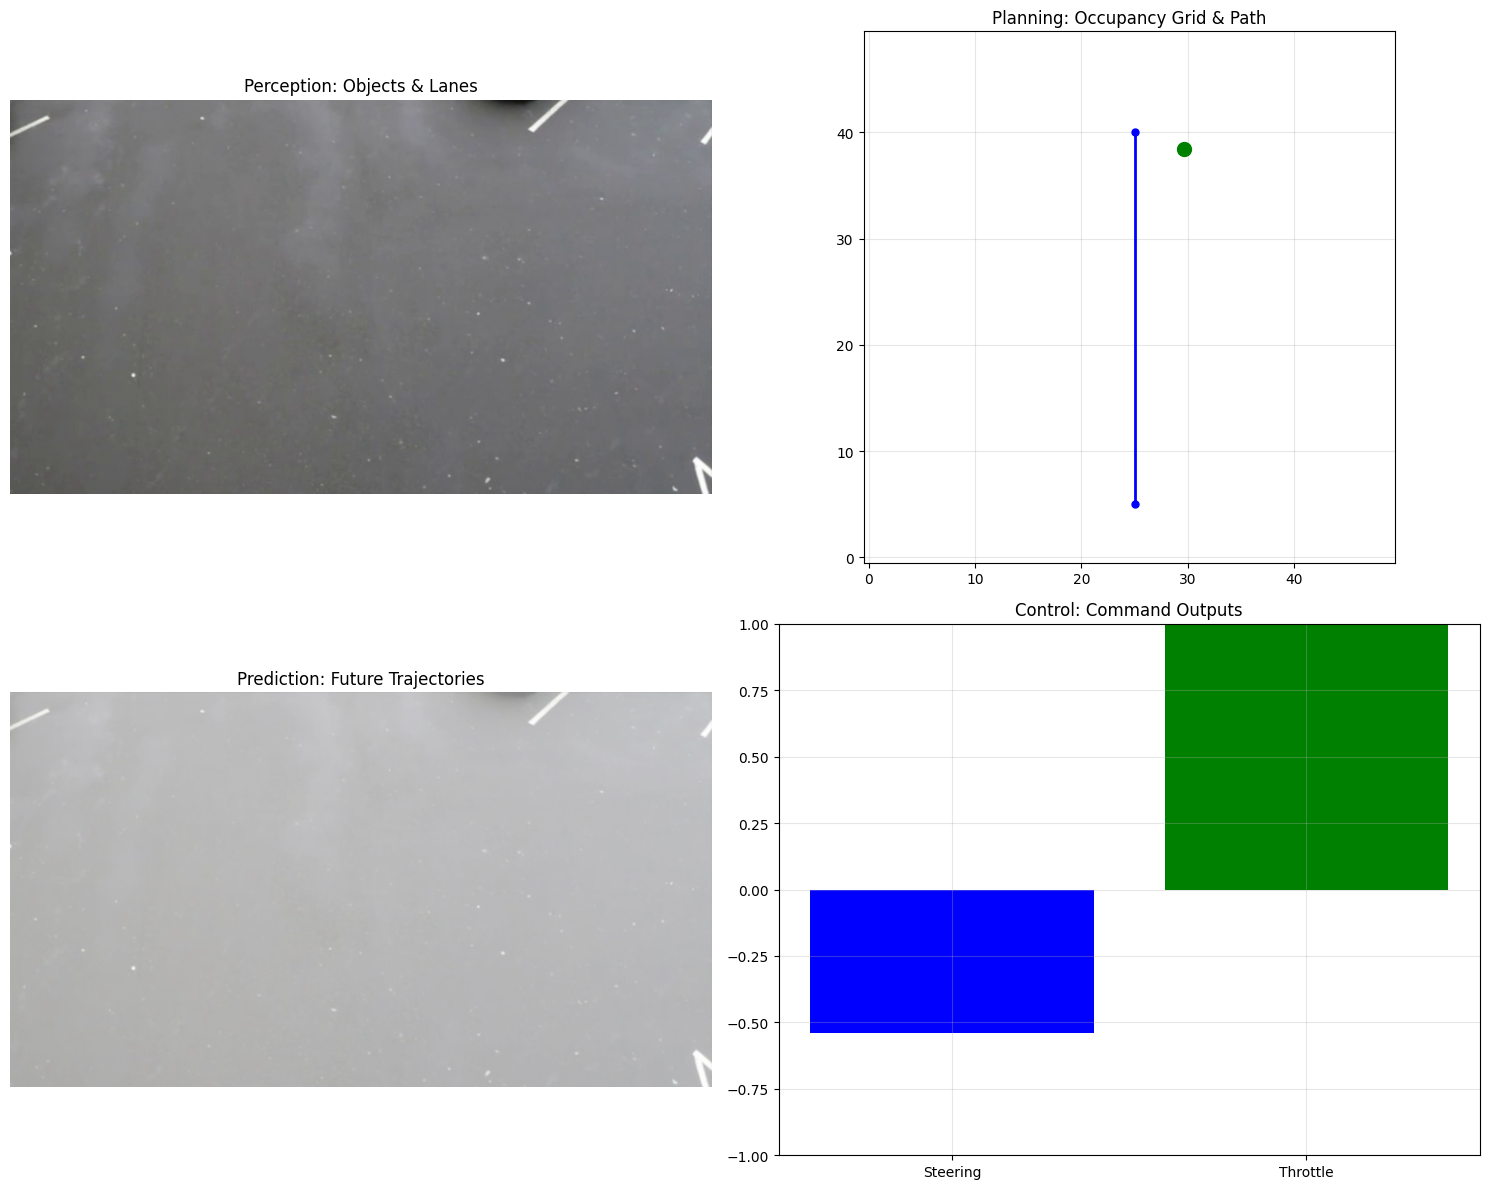

In [11]:
# Initialize pipeline
pipeline = AVPipeline()

# Process video or images
video_path = 'sample_video.mp4'
cap = cv2.VideoCapture(video_path)

# Process first few frames
frame_count = 0
max_frames = 10  # Limit for demonstration

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    results = pipeline.process_frame(frame)

    # Visualize results
    pipeline.visualize_results(frame, results)

    frame_count += 1

cap.release()

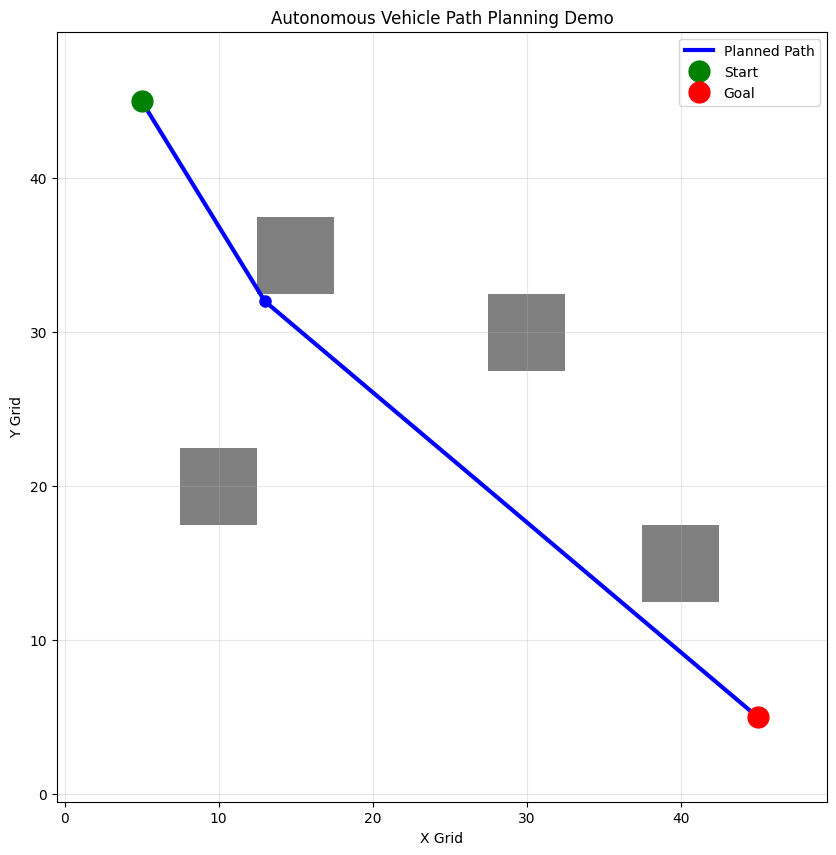

In [12]:
def create_interactive_demo():
    """Create an interactive visualization with simulated data"""
    # Create synthetic scenario
    fig, ax = plt.subplots(figsize=(10, 10))

    # Simulated obstacles
    obstacles = [(10, 20), (30, 30), (40, 15), (15, 35)]

    # Create occupancy grid
    occupancy_grid = np.zeros((50, 50))
    for obs in obstacles:
        x, y = obs
        occupancy_grid[y-2:y+3, x-2:x+3] = 1

    # Initialize modules
    planning = PlanningModule()
    control = ControlModule()

    # Vehicle starting position
    start = (5, 45)
    goal = (45, 5)

    # Plan path
    path = planning.a_star(start, goal, occupancy_grid)
    if path:
        path = planning.smooth_path(path, occupancy_grid)

    # Visualization
    ax.imshow(occupancy_grid, cmap='binary', origin='lower', alpha=0.5)

    # Plot path
    if path:
        path_array = np.array(path)
        ax.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=3, label='Planned Path')
        ax.plot(path_array[:, 0], path_array[:, 1], 'bo', markersize=8)

    # Mark start and goal
    ax.plot(start[0], start[1], 'go', markersize=15, label='Start')
    ax.plot(goal[0], goal[1], 'ro', markersize=15, label='Goal')

    # Add grid
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_title('Autonomous Vehicle Path Planning Demo')
    ax.set_xlabel('X Grid')
    ax.set_ylabel('Y Grid')

    plt.show()

# Run interactive demo
create_interactive_demo()

Initializing Autonomous Vehicle Demo...
Running simulation...
The vehicle (green) will navigate to the goal (gold) while avoiding obstacles
Red objects are dynamic vehicles with predicted trajectories
The system uses perception, prediction, planning, and control modules


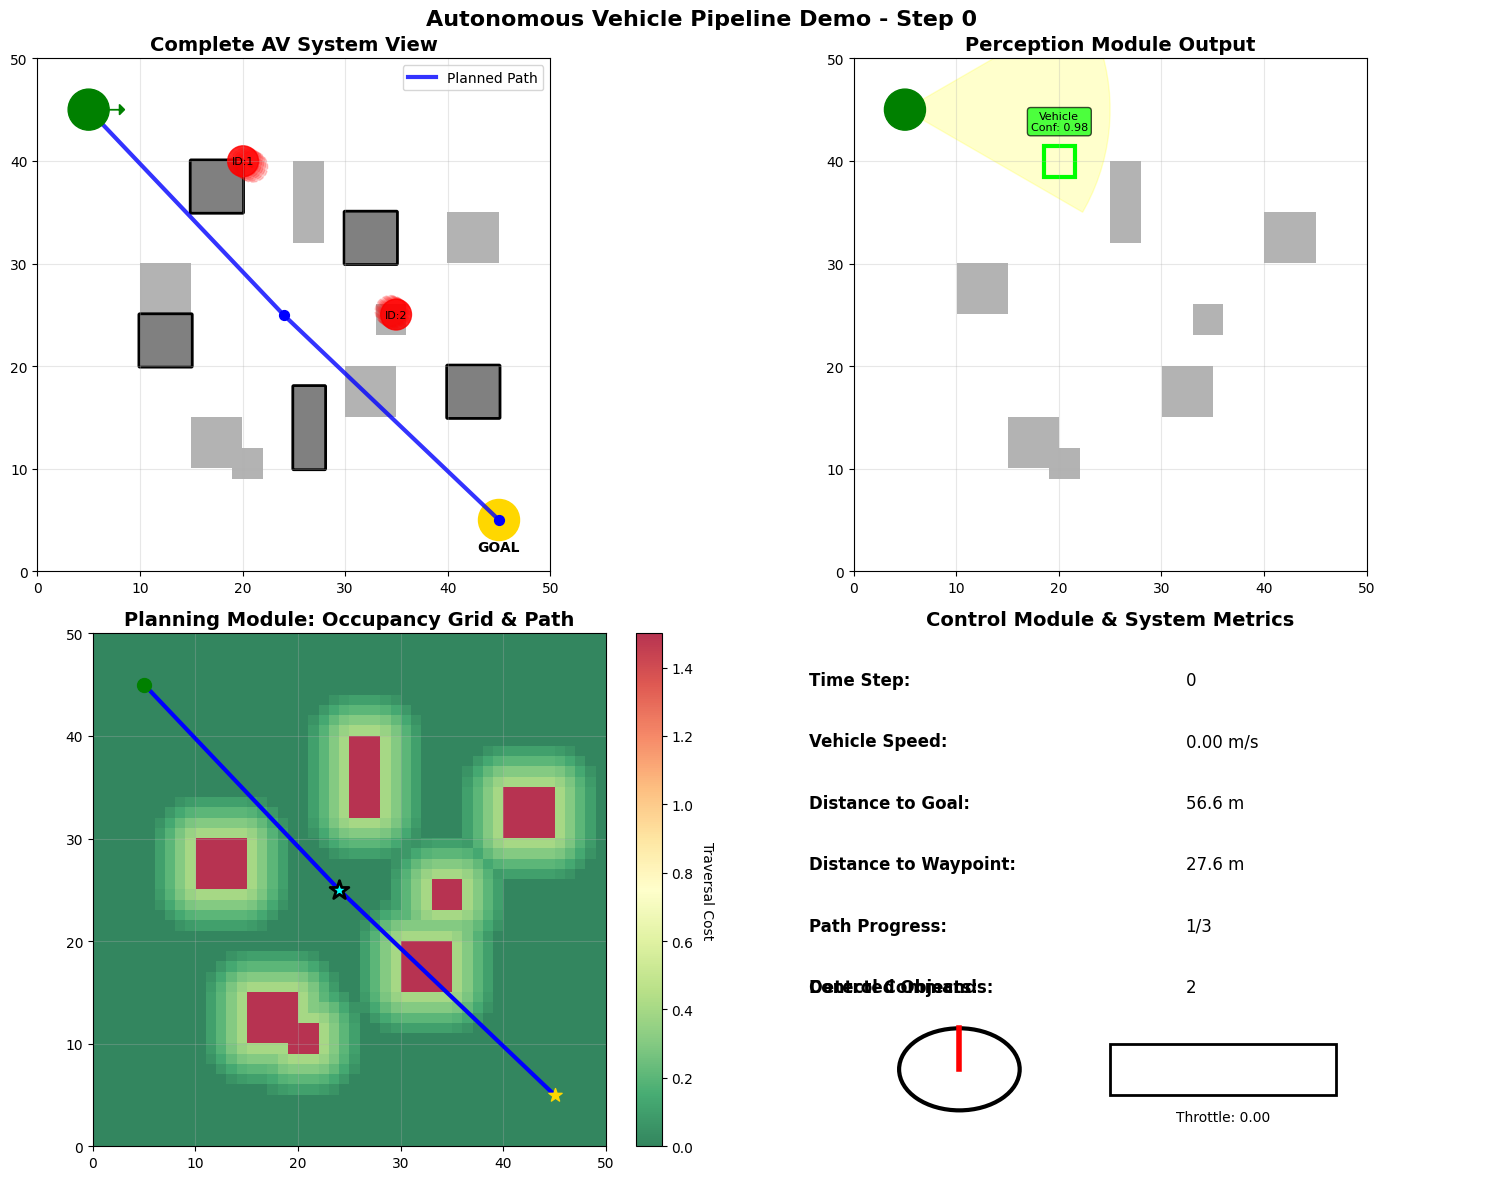

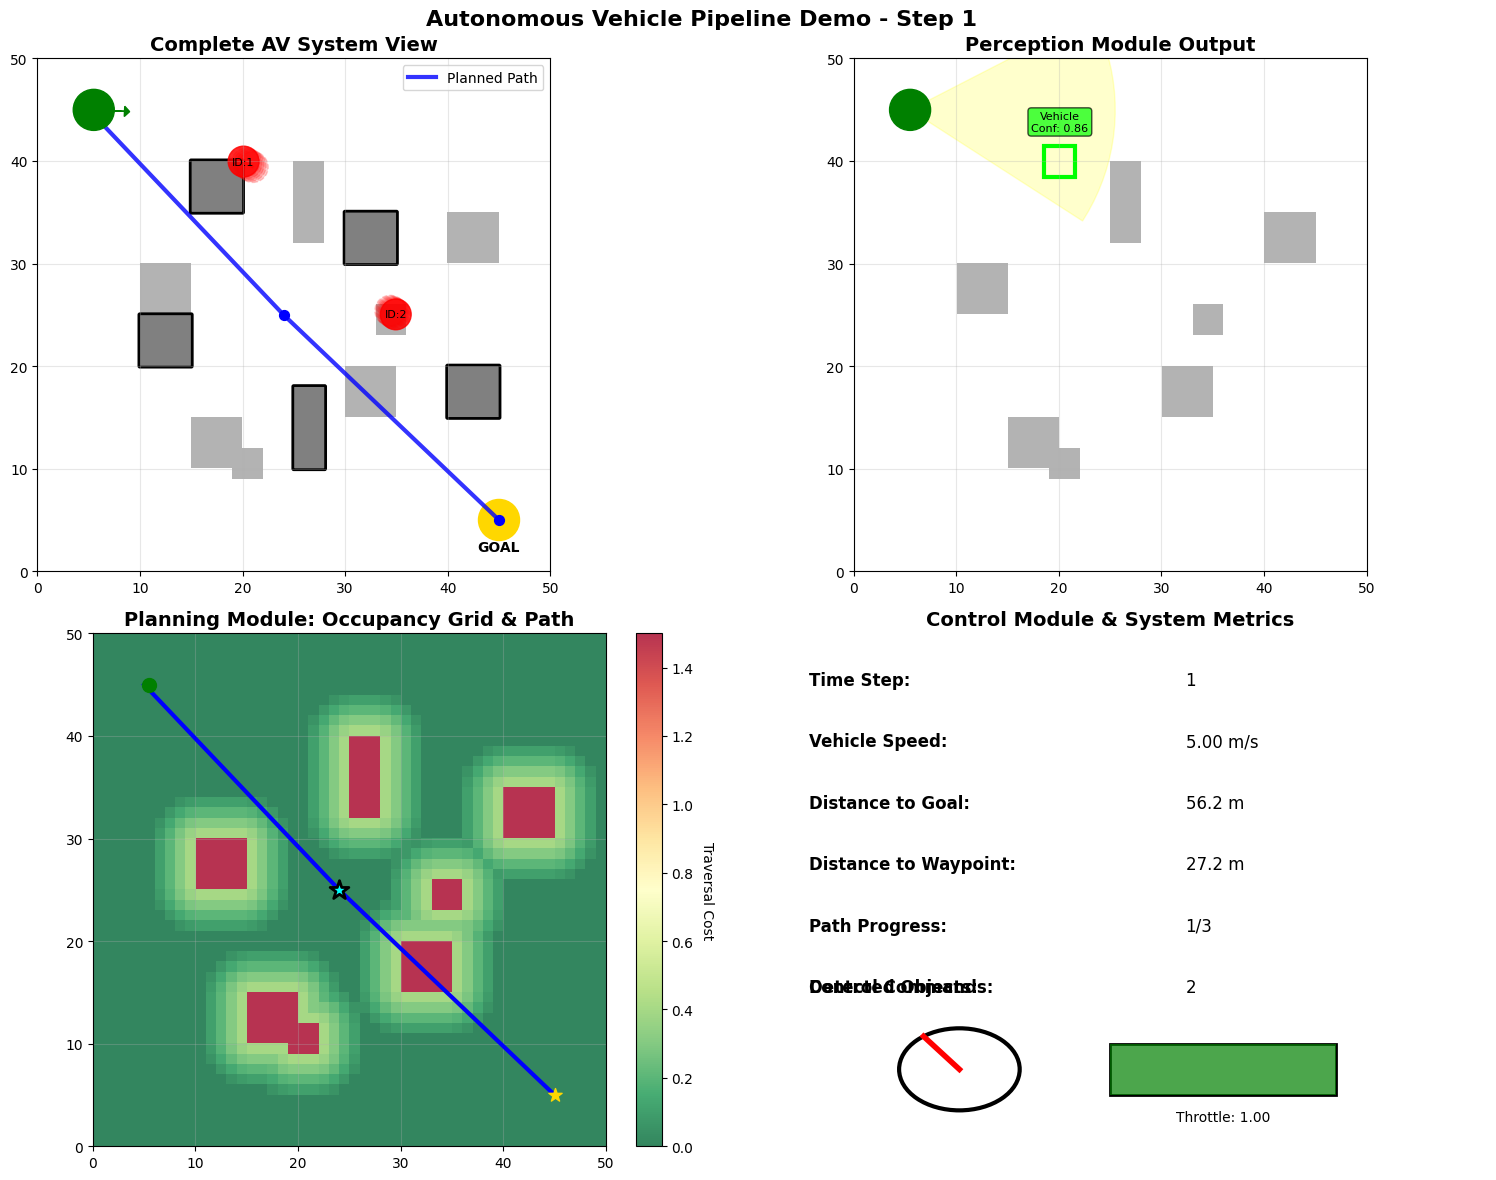

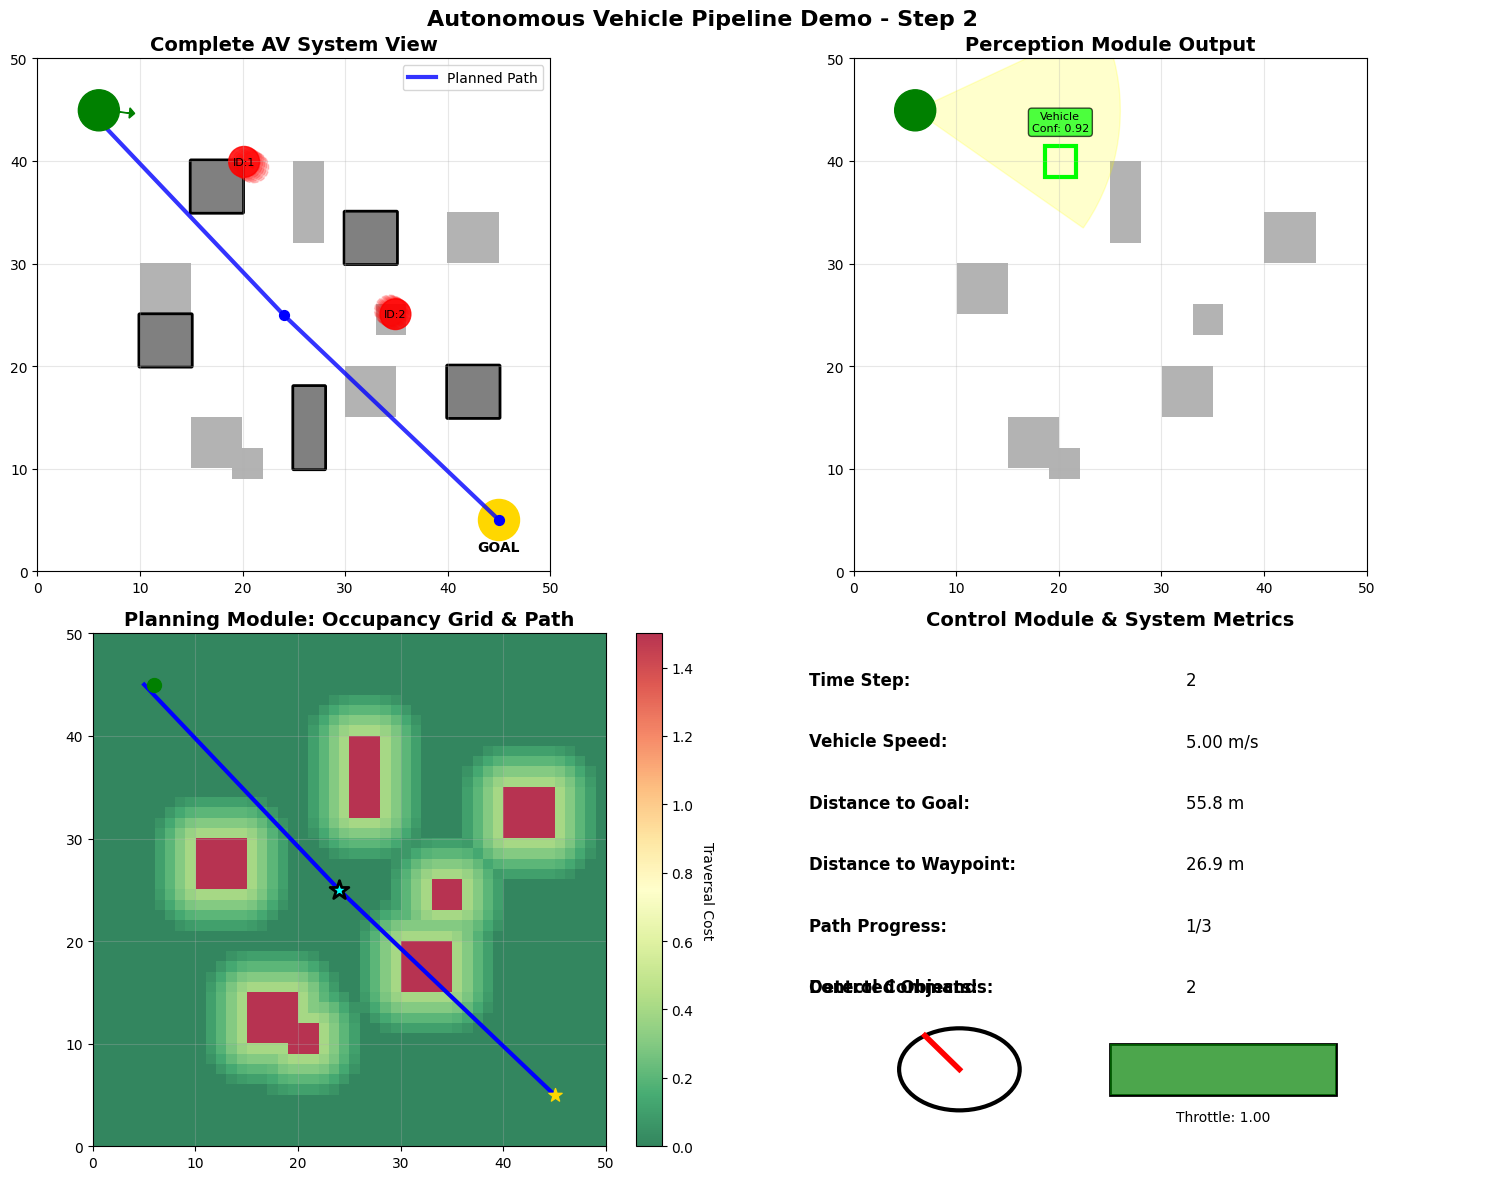

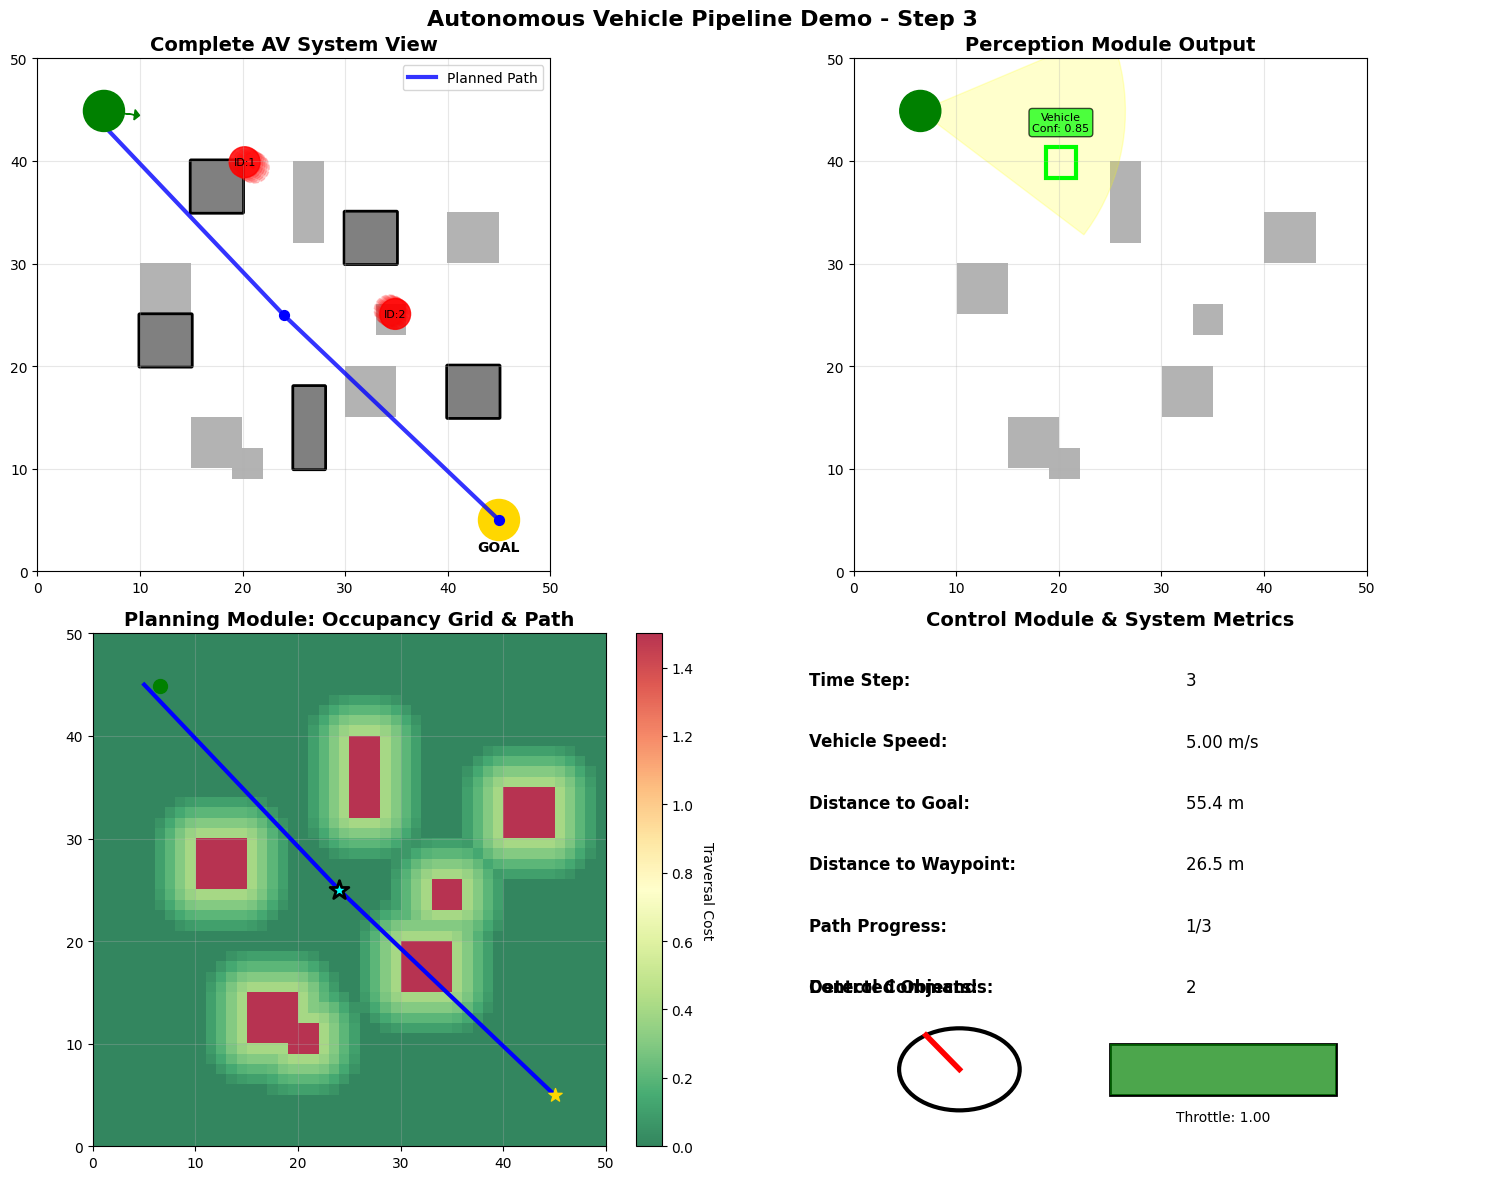

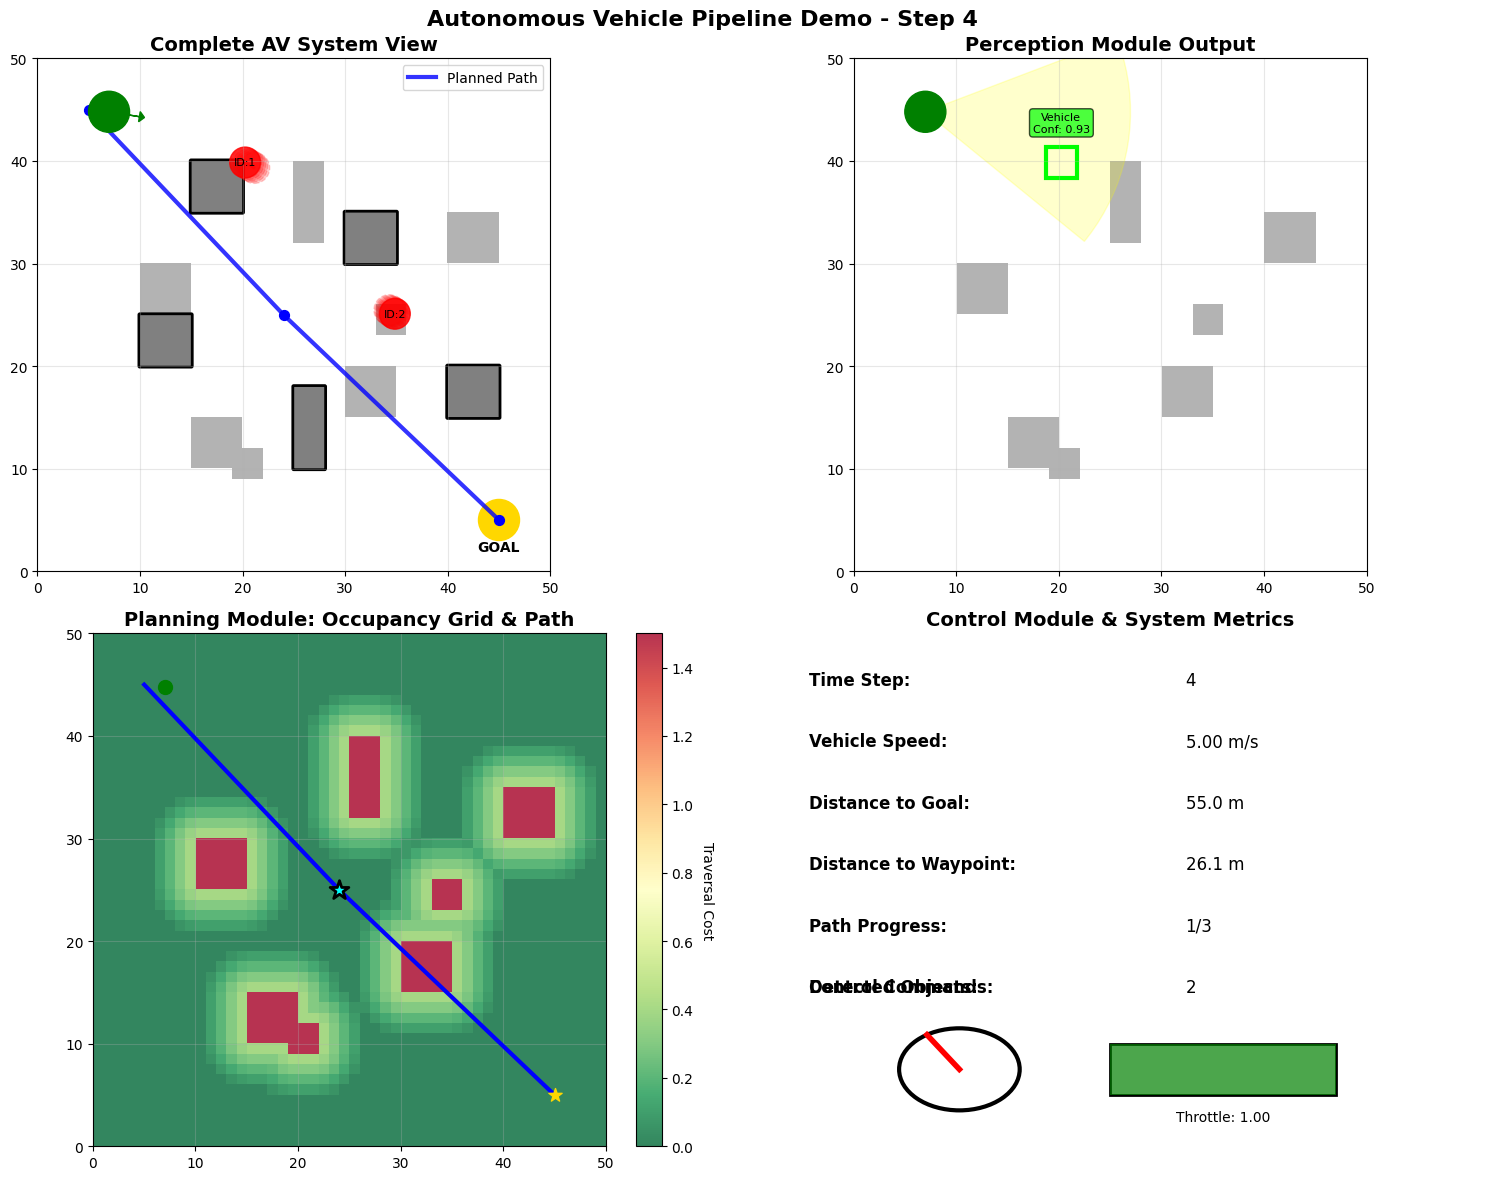


Demo completed! The visualization shows:
- Top Left: Complete system view with all components
- Top Right: Perception module detecting objects in camera FOV
- Bottom Left: Planning module with cost map and planned path
- Bottom Right: Control commands and system metrics


In [14]:
# Complete Autonomous Vehicle Pipeline Demo
# Run this after the setup code from the previous guide

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyBboxPatch
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time

# Create a complete demo with simulated sensor data
class SimulatedAVDemo:
    def __init__(self):
        # Grid parameters
        self.grid_size = (50, 50)
        self.cell_size = 10  # pixels per grid cell

        # Create simulated environment
        self.static_obstacles = [
            (10, 20, 5, 5),   # (x, y, width, height)
            (30, 30, 5, 5),
            (40, 15, 5, 5),
            (15, 35, 5, 5),
            (25, 10, 3, 8),
        ]

        # Dynamic objects (other vehicles)
        self.dynamic_objects = [
            {'id': 1, 'pos': [20, 40], 'vel': [0.5, -0.3], 'size': 3},
            {'id': 2, 'pos': [35, 25], 'vel': [-0.3, 0.2], 'size': 3},
        ]

        # Initialize modules
        self.init_modules()

        # Vehicle state
        self.vehicle_pos = np.array([5.0, 45.0])
        self.vehicle_heading = 0.0
        self.vehicle_vel = 0.0
        self.goal = (45, 5)

        # Path and control
        self.current_path = []
        self.path_index = 0

        # Visualization history
        self.history = {
            'vehicle_pos': [],
            'dynamic_pos': {obj['id']: [] for obj in self.dynamic_objects},
            'predictions': [],
        }

    def init_modules(self):
        """Initialize simplified versions of each module"""
        # We'll use the modules from the main guide
        self.planning = PlanningModule(self.grid_size)
        self.control = ControlModule()

        # Simplified Kalman filter for tracking
        from filterpy.kalman import KalmanFilter
        self.trackers = {}

    def create_occupancy_grid(self):
        """Create occupancy grid from static and dynamic obstacles"""
        grid = np.zeros(self.grid_size)

        # Add static obstacles
        for x, y, w, h in self.static_obstacles:
            grid[y:y+h, x:x+w] = 1

        # Add dynamic objects
        for obj in self.dynamic_objects:
            x, y = int(obj['pos'][0]), int(obj['pos'][1])
            size = obj['size']
            x1, y1 = max(0, x-size//2), max(0, y-size//2)
            x2, y2 = min(self.grid_size[0], x+size//2+1), min(self.grid_size[1], y+size//2+1)
            grid[y1:y2, x1:x2] = 1

        return grid

    def update_dynamic_objects(self, dt):
        """Update positions of dynamic objects"""
        for obj in self.dynamic_objects:
            # Update position
            obj['pos'][0] += obj['vel'][0] * dt
            obj['pos'][1] += obj['vel'][1] * dt

            # Bounce off walls
            if obj['pos'][0] <= 0 or obj['pos'][0] >= self.grid_size[0]:
                obj['vel'][0] *= -1
            if obj['pos'][1] <= 0 or obj['pos'][1] >= self.grid_size[1]:
                obj['vel'][1] *= -1

            # Keep in bounds
            obj['pos'][0] = np.clip(obj['pos'][0], 0, self.grid_size[0]-1)
            obj['pos'][1] = np.clip(obj['pos'][1], 0, self.grid_size[1]-1)

    def predict_trajectories(self, time_horizon=2.0, dt=0.2):
        """Predict future positions of dynamic objects"""
        predictions = {}
        steps = int(time_horizon / dt)

        for obj in self.dynamic_objects:
            predictions[obj['id']] = []
            pos = obj['pos'].copy()
            vel = obj['vel'].copy()

            for _ in range(steps):
                pos[0] += vel[0] * dt
                pos[1] += vel[1] * dt
                predictions[obj['id']].append(pos.copy())

        return predictions

    def plan_path(self, occupancy_grid):
        """Plan or replan path if needed"""
        start = (int(self.vehicle_pos[0]), int(self.vehicle_pos[1]))

        # Check if we need to replan
        need_replan = False
        if not self.current_path:
            need_replan = True
        elif len(self.current_path) > self.path_index:
            # Check if current path is blocked
            next_waypoint = self.current_path[self.path_index]
            if occupancy_grid[next_waypoint[1], next_waypoint[0]] == 1:
                need_replan = True

        if need_replan:
            path = self.planning.a_star(start, self.goal, occupancy_grid)
            if path:
                self.current_path = self.planning.smooth_path(path, occupancy_grid)
                self.path_index = 0

    def execute_control(self, dt):
        """Execute control commands"""
        if self.current_path and self.path_index < len(self.current_path):
            # Get target waypoint
            target = self.current_path[self.path_index]

            # Compute control
            steering, throttle = self.control.compute_control(
                self.vehicle_pos, target, self.vehicle_heading
            )

            # Update vehicle state (simple bicycle model)
            self.vehicle_vel = throttle * 5.0  # Max speed
            self.vehicle_heading += steering * dt

            # Update position
            dx = self.vehicle_vel * np.cos(self.vehicle_heading) * dt
            dy = self.vehicle_vel * np.sin(self.vehicle_heading) * dt

            new_pos = self.vehicle_pos + np.array([dx, dy])

            # Check collision
            occupancy_grid = self.create_occupancy_grid()
            new_x, new_y = int(new_pos[0]), int(new_pos[1])

            if (0 <= new_x < self.grid_size[0] and
                0 <= new_y < self.grid_size[1] and
                occupancy_grid[new_y, new_x] == 0):
                self.vehicle_pos = new_pos

            # Check if reached waypoint
            dist_to_waypoint = np.linalg.norm(self.vehicle_pos - np.array(target))
            if dist_to_waypoint < 2.0:
                self.path_index += 1

    def step(self, dt=0.1):
        """Run one step of the simulation"""
        # Update dynamic objects
        self.update_dynamic_objects(dt)

        # Create occupancy grid
        occupancy_grid = self.create_occupancy_grid()

        # Predict trajectories
        predictions = self.predict_trajectories()

        # Plan path
        self.plan_path(occupancy_grid)

        # Execute control
        self.execute_control(dt)

        # Store history
        self.history['vehicle_pos'].append(self.vehicle_pos.copy())
        for obj in self.dynamic_objects:
            self.history['dynamic_pos'][obj['id']].append(obj['pos'].copy())
        self.history['predictions'].append(predictions)

        return {
            'occupancy_grid': occupancy_grid,
            'predictions': predictions,
            'path': self.current_path,
            'vehicle_pos': self.vehicle_pos,
            'vehicle_heading': self.vehicle_heading,
            'dynamic_objects': self.dynamic_objects,
        }

    def visualize_state(self, state, step_num):
        """Create comprehensive visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Main view with everything
        ax1 = axes[0, 0]
        ax1.set_title('Complete AV System View', fontsize=14, fontweight='bold')

        # Draw occupancy grid
        ax1.imshow(state['occupancy_grid'], cmap='gray_r', alpha=0.3, extent=[0, 50, 0, 50])

        # Draw static obstacles
        for x, y, w, h in self.static_obstacles:
            rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1",
                                 facecolor='gray', edgecolor='black', linewidth=2)
            ax1.add_patch(rect)

        # Draw dynamic objects with predictions
        for obj in state['dynamic_objects']:
            # Current position
            circle = Circle(obj['pos'], obj['size']/2, color='red', alpha=0.8)
            ax1.add_patch(circle)
            ax1.text(obj['pos'][0], obj['pos'][1], f"ID:{obj['id']}",
                    fontsize=8, ha='center', va='center')

            # Predictions
            if obj['id'] in state['predictions']:
                pred_positions = state['predictions'][obj['id']]
                if pred_positions:
                    pred_array = np.array(pred_positions)
                    ax1.plot(pred_array[:, 0], pred_array[:, 1], 'r--',
                            alpha=0.5, linewidth=2)
                    for i, pos in enumerate(pred_positions[::2]):  # Show every other prediction
                        circle = Circle(pos, obj['size']/2, color='red',
                                      alpha=0.2, linestyle='--')
                        ax1.add_patch(circle)

        # Draw path
        if state['path']:
            path_array = np.array(state['path'])
            ax1.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=3,
                    label='Planned Path', alpha=0.8)
            ax1.scatter(path_array[:, 0], path_array[:, 1], c='blue', s=50, zorder=5)

        # Draw vehicle
        vehicle_marker = Circle(state['vehicle_pos'], 2, color='green', zorder=10)
        ax1.add_patch(vehicle_marker)

        # Draw vehicle heading
        head_len = 3
        dx = head_len * np.cos(state['vehicle_heading'])
        dy = head_len * np.sin(state['vehicle_heading'])
        ax1.arrow(state['vehicle_pos'][0], state['vehicle_pos'][1], dx, dy,
                 head_width=1, head_length=0.5, fc='green', ec='green', zorder=11)

        # Draw goal
        goal_marker = Circle(self.goal, 2, color='gold')
        ax1.add_patch(goal_marker)
        ax1.text(self.goal[0], self.goal[1]-3, 'GOAL', fontsize=10,
                ha='center', fontweight='bold')

        ax1.set_xlim(0, 50)
        ax1.set_ylim(0, 50)
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        ax1.legend()

        # 2. Perception view (bird's eye with detections)
        ax2 = axes[0, 1]
        ax2.set_title('Perception Module Output', fontsize=14, fontweight='bold')

        # Create synthetic camera view
        camera_range = 20
        camera_fov = np.pi/3  # 60 degrees

        # Draw camera FOV
        fov_points = [state['vehicle_pos']]
        for angle in np.linspace(state['vehicle_heading'] - camera_fov/2,
                               state['vehicle_heading'] + camera_fov/2, 20):
            x = state['vehicle_pos'][0] + camera_range * np.cos(angle)
            y = state['vehicle_pos'][1] + camera_range * np.sin(angle)
            fov_points.append([x, y])
        fov_points.append(state['vehicle_pos'])

        fov_poly = plt.Polygon(fov_points, alpha=0.2, color='yellow')
        ax2.add_patch(fov_poly)

        # Show detected objects in FOV
        ax2.imshow(state['occupancy_grid'], cmap='gray_r', alpha=0.3, extent=[0, 50, 0, 50])

        for obj in state['dynamic_objects']:
            # Check if in FOV
            rel_pos = obj['pos'] - state['vehicle_pos']
            dist = np.linalg.norm(rel_pos)
            angle = np.arctan2(rel_pos[1], rel_pos[0])
            angle_diff = np.abs(np.arctan2(np.sin(angle - state['vehicle_heading']),
                                          np.cos(angle - state['vehicle_heading'])))

            if dist < camera_range and angle_diff < camera_fov/2:
                # Object is detected
                rect = Rectangle((obj['pos'][0] - obj['size']/2,
                                obj['pos'][1] - obj['size']/2),
                               obj['size'], obj['size'],
                               linewidth=3, edgecolor='lime', facecolor='none')
                ax2.add_patch(rect)
                ax2.text(obj['pos'][0], obj['pos'][1] + obj['size'],
                        f'Vehicle\nConf: 0.{np.random.randint(85, 99)}',
                        fontsize=8, ha='center',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='lime', alpha=0.7))

        # Draw vehicle
        vehicle_marker = Circle(state['vehicle_pos'], 2, color='green', zorder=10)
        ax2.add_patch(vehicle_marker)

        ax2.set_xlim(0, 50)
        ax2.set_ylim(0, 50)
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal')

        # 3. Planning view
        ax3 = axes[1, 0]
        ax3.set_title('Planning Module: Occupancy Grid & Path', fontsize=14, fontweight='bold')

        # Show occupancy grid with costs
        cost_grid = state['occupancy_grid'].copy().astype(float)

        # Add gradient costs around obstacles
        from scipy.ndimage import distance_transform_edt
        obstacle_dist = distance_transform_edt(1 - state['occupancy_grid'])
        cost_grid += np.maximum(0, 1 - obstacle_dist / 5) * 0.5

        im = ax3.imshow(cost_grid, cmap='RdYlGn_r', extent=[0, 50, 0, 50], alpha=0.8)

        # Draw path with waypoints
        if state['path']:
            path_array = np.array(state['path'])
            ax3.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=3)

            # Highlight current waypoint
            if self.path_index < len(state['path']):
                current_wp = state['path'][self.path_index]
                ax3.scatter(current_wp[0], current_wp[1], c='cyan', s=200,
                          marker='*', edgecolor='black', linewidth=2, zorder=10)

        # Vehicle and goal
        ax3.scatter(state['vehicle_pos'][0], state['vehicle_pos'][1],
                   c='green', s=100, marker='o', zorder=10)
        ax3.scatter(self.goal[0], self.goal[1], c='gold', s=100, marker='*', zorder=10)

        ax3.set_xlim(0, 50)
        ax3.set_ylim(0, 50)
        ax3.grid(True, alpha=0.3)
        ax3.set_aspect('equal')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
        cbar.set_label('Traversal Cost', rotation=270, labelpad=15)

        # 4. Control and metrics
        ax4 = axes[1, 1]
        ax4.set_title('Control Module & System Metrics', fontsize=14, fontweight='bold')

        # Calculate metrics
        if self.path_index < len(self.current_path):
            target = self.current_path[self.path_index]
            distance_to_waypoint = np.linalg.norm(state['vehicle_pos'] - np.array(target))
            distance_to_goal = np.linalg.norm(state['vehicle_pos'] - np.array(self.goal))
        else:
            distance_to_waypoint = 0
            distance_to_goal = np.linalg.norm(state['vehicle_pos'] - np.array(self.goal))

        # Control signals
        if hasattr(self.control, 'prev_steering_error'):
            steering = self.control.prev_steering_error
            throttle = min(1.0, self.control.prev_throttle_error * self.control.kp_throttle)
        else:
            steering = 0
            throttle = 0

        # Create dashboard
        metrics = [
            ('Time Step', step_num),
            ('Vehicle Speed', f'{self.vehicle_vel:.2f} m/s'),
            ('Distance to Goal', f'{distance_to_goal:.1f} m'),
            ('Distance to Waypoint', f'{distance_to_waypoint:.1f} m'),
            ('Path Progress', f'{self.path_index}/{len(self.current_path) if self.current_path else 0}'),
            ('Detected Objects', len([o for o in state['dynamic_objects']])),
        ]

        y_pos = 0.9
        for label, value in metrics:
            ax4.text(0.1, y_pos, f'{label}:', fontsize=12, fontweight='bold')
            ax4.text(0.6, y_pos, str(value), fontsize=12)
            y_pos -= 0.12

        # Control visualization
        ax4.text(0.1, 0.3, 'Control Commands:', fontsize=12, fontweight='bold')

        # Steering wheel
        wheel_center = (0.3, 0.15)
        wheel = Circle(wheel_center, 0.08, fill=False, linewidth=3)
        ax4.add_patch(wheel)

        # Steering indicator
        steer_angle = steering * np.pi/4  # Max 45 degrees
        steer_x = wheel_center[0] + 0.08 * np.sin(steer_angle)
        steer_y = wheel_center[1] + 0.08 * np.cos(steer_angle)
        ax4.plot([wheel_center[0], steer_x], [wheel_center[1], steer_y],
                'r-', linewidth=4)

        # Throttle bar
        throttle_rect = Rectangle((0.5, 0.1), 0.3, 0.1,
                                facecolor='none', edgecolor='black', linewidth=2)
        ax4.add_patch(throttle_rect)
        throttle_fill = Rectangle((0.5, 0.1), 0.3 * throttle, 0.1,
                                facecolor='green', alpha=0.7)
        ax4.add_patch(throttle_fill)
        ax4.text(0.65, 0.05, f'Throttle: {throttle:.2f}', fontsize=10, ha='center')

        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')

        plt.suptitle(f'Autonomous Vehicle Pipeline Demo - Step {step_num}',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()

        return fig

    def run_simulation(self, steps=100, dt=0.1, save_frames=False):
        """Run the complete simulation"""
        frames = []

        for i in range(steps):
            # Run one step
            state = self.step(dt)

            # Visualize
            fig = self.visualize_state(state, i)

            if save_frames:
                frames.append(fig)
            else:
                plt.show()
                time.sleep(0.1)  # Small delay for visualization

            plt.close(fig)

            # Check if reached goal
            dist_to_goal = np.linalg.norm(self.vehicle_pos - np.array(self.goal))
            if dist_to_goal < 2.0:
                print(f"Goal reached in {i} steps!")
                break

        return frames

# Run the demo
print("Initializing Autonomous Vehicle Demo...")
demo = SimulatedAVDemo()

print("Running simulation...")
print("The vehicle (green) will navigate to the goal (gold) while avoiding obstacles")
print("Red objects are dynamic vehicles with predicted trajectories")
print("The system uses perception, prediction, planning, and control modules")

# Run for a few steps to show in Colab
for i in range(5):
    state = demo.step(0.1)
    fig = demo.visualize_state(state, i)
    plt.show()
    time.sleep(0.5)  # Pause between frames

print("\nDemo completed! The visualization shows:")
print("- Top Left: Complete system view with all components")
print("- Top Right: Perception module detecting objects in camera FOV")
print("- Bottom Left: Planning module with cost map and planned path")
print("- Bottom Right: Control commands and system metrics")

=== Advanced Autonomous Vehicle Features Demo ===

1. Advanced Lane Detection


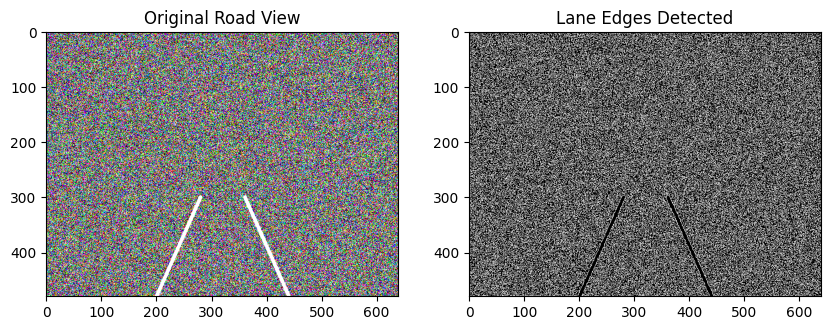


2. LSTM Trajectory Prediction


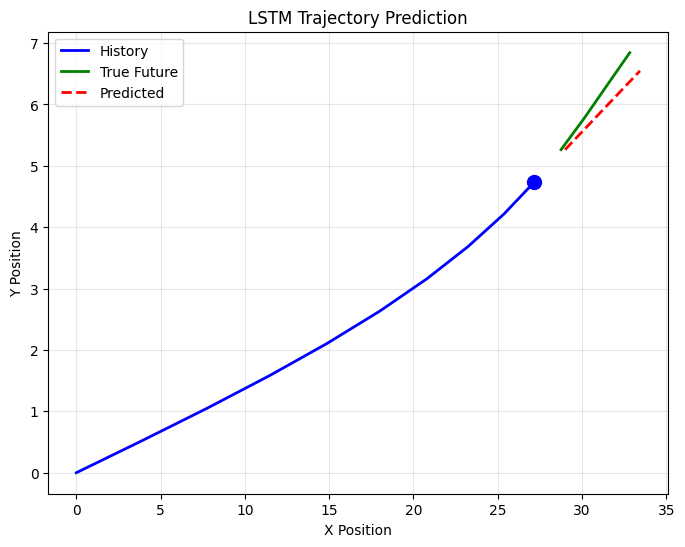


3. Model Predictive Control


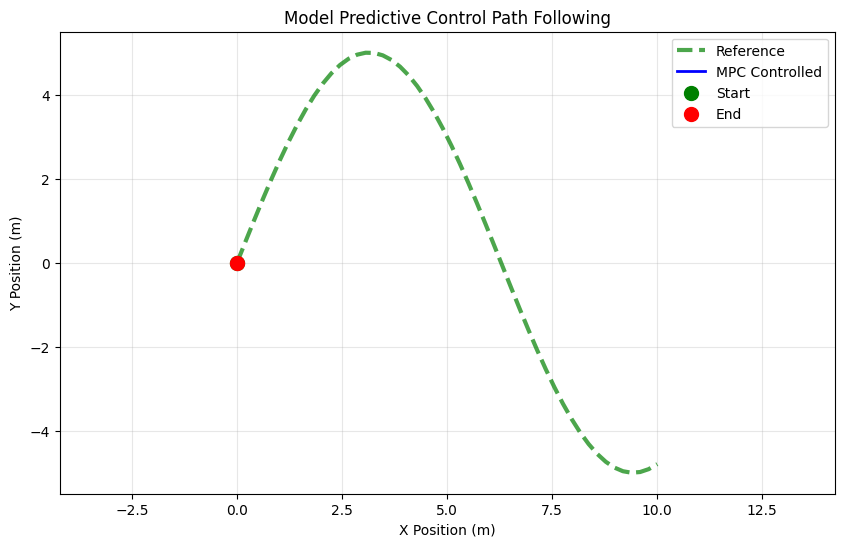


=== Demo Complete ===
These advanced features can be integrated into the main pipeline:
- Lane detection for lane keeping assist
- LSTM for better trajectory prediction
- MPC for smoother, more optimal control


In [15]:
# Enhanced Features for the AV Pipeline
# Add these features to your existing pipeline

# 1. Real Video Processing with YOLO
class RealVideoProcessor:
    def __init__(self):
        self.perception = PerceptionModule()
        self.prediction = PredictionModule()
        self.planning = PlanningModule()
        self.control = ControlModule()

        # For video recording
        self.output_frames = []

    def process_video(self, video_path, max_frames=None):
        """Process a real driving video"""
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        print(f"Processing video: {width}x{height} @ {fps} FPS")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret or (max_frames and frame_count >= max_frames):
                break

            # Process frame
            results = self.process_frame(frame)

            # Visualize
            vis_frame = self.visualize_frame(frame, results)
            self.output_frames.append(vis_frame)

            # Display in Colab
            if frame_count % 10 == 0:  # Show every 10th frame
                plt.figure(figsize=(12, 8))
                plt.imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Frame {frame_count}')
                plt.axis('off')
                plt.show()

            frame_count += 1

        cap.release()
        print(f"Processed {frame_count} frames")

    def process_frame(self, frame):
        """Process single frame through pipeline"""
        # Perception
        detections = self.perception.detect_objects(frame)
        lanes = self.perception.detect_lanes(frame)

        # Create bird's eye view occupancy grid
        bev_grid = self.create_bev_from_detections(detections, frame.shape)

        # Prediction
        self.prediction.update_trackers(detections)
        predictions = self.prediction.predict_positions()

        # Planning (simplified for demo)
        # In real scenario, you'd transform this to vehicle coordinates

        return {
            'detections': detections,
            'lanes': lanes,
            'predictions': predictions,
            'bev_grid': bev_grid
        }

    def create_bev_from_detections(self, detections, frame_shape):
        """Convert camera detections to bird's eye view"""
        # Simplified BEV - in practice use homography
        h, w = frame_shape[:2]
        bev_size = (100, 100)  # 100x100 grid
        bev_grid = np.zeros(bev_size)

        for det in detections:
            # Simple mapping: bottom of frame = close, top = far
            x1, y1, x2, y2 = det['bbox']

            # Map to BEV (very simplified)
            bev_y = int((1 - y2/h) * bev_size[0])  # Invert and scale
            bev_x = int((x1 + x2)/(2*w) * bev_size[1])  # Center x

            # Mark area as occupied
            size = max(3, int(10 * (1 - y2/h)))  # Larger when closer
            y_start = max(0, bev_y - size//2)
            y_end = min(bev_size[0], bev_y + size//2)
            x_start = max(0, bev_x - size//2)
            x_end = min(bev_size[1], bev_x + size//2)

            bev_grid[y_start:y_end, x_start:x_end] = 1

        return bev_grid

    def visualize_frame(self, frame, results):
        """Create visualization overlay"""
        vis_frame = frame.copy()

        # Draw detections
        for det in results['detections']:
            x1, y1, x2, y2 = [int(x) for x in det['bbox']]
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add label
            label = f"Vehicle {det['confidence']:.2f}"
            cv2.putText(vis_frame, label, (x1, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw lanes
        for line in results['lanes']:
            (x1, y1), (x2, y2) = line
            cv2.line(vis_frame, (x1, y1), (x2, y2), (0, 0, 255), 3)

        # Add mini BEV view
        bev_vis = (results['bev_grid'] * 255).astype(np.uint8)
        bev_vis = cv2.resize(bev_vis, (200, 200))
        bev_vis = cv2.cvtColor(bev_vis, cv2.COLOR_GRAY2BGR)

        # Place BEV in corner
        vis_frame[10:210, 10:210] = bev_vis
        cv2.putText(vis_frame, "Bird's Eye View", (10, 225),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        return vis_frame

# 2. Advanced Lane Detection with CNN
class AdvancedLaneDetector:
    def __init__(self):
        self.initialize_model()

    def initialize_model(self):
        """Initialize or load a lane detection model"""
        # For demo, we'll use traditional CV
        # In practice, you'd load a model like SCNN, LaneNet, etc.
        pass

    def detect_lanes_advanced(self, frame):
        """Advanced lane detection with curve fitting"""
        # Preprocessing
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply perspective transform for bird's eye view
        h, w = gray.shape
        src_points = np.float32([
            [w*0.45, h*0.65],  # Top left
            [w*0.55, h*0.65],  # Top right
            [w*0.9, h*0.9],    # Bottom right
            [w*0.1, h*0.9]     # Bottom left
        ])

        dst_points = np.float32([
            [w*0.3, 0],     # Top left
            [w*0.7, 0],     # Top right
            [w*0.7, h],     # Bottom right
            [w*0.3, h]      # Bottom left
        ])

        # Get transform matrix
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        warped = cv2.warpPerspective(gray, M, (w, h))

        # Detect lanes in warped image
        lanes = self.sliding_window_detection(warped)

        # Transform back to original perspective
        Minv = cv2.getPerspectiveTransform(dst_points, src_points)

        return lanes, warped, Minv

    def sliding_window_detection(self, binary_warped):
        """Sliding window lane detection"""
        # Take histogram of bottom half
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Find peaks for left and right lanes
        midpoint = len(histogram)//2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Sliding windows
        nwindows = 9
        window_height = binary_warped.shape[0] // nwindows

        # Current positions
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Width of windows
        margin = 100
        minpix = 50

        # Lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through windows
        for window in range(nwindows):
            # Window boundaries
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify pixels in window
            good_left_inds = ((binary_warped.nonzero()[0] >= win_y_low) &
                             (binary_warped.nonzero()[0] < win_y_high) &
                             (binary_warped.nonzero()[1] >= win_xleft_low) &
                             (binary_warped.nonzero()[1] < win_xleft_high)).nonzero()[0]

            good_right_inds = ((binary_warped.nonzero()[0] >= win_y_low) &
                              (binary_warped.nonzero()[0] < win_y_high) &
                              (binary_warped.nonzero()[1] >= win_xright_low) &
                              (binary_warped.nonzero()[1] < win_xright_high)).nonzero()[0]

            # Append indices
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # Recenter next window
            if len(good_left_inds) > minpix:
                leftx_current = int(np.mean(binary_warped.nonzero()[1][good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = int(np.mean(binary_warped.nonzero()[1][good_right_inds]))

        # Concatenate indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        return {
            'left_indices': left_lane_inds,
            'right_indices': right_lane_inds,
            'left_base': leftx_base,
            'right_base': rightx_base
        }

# 3. Behavior Prediction with LSTM
class LSTMPredictor:
    def __init__(self, input_size=4, hidden_size=64, output_size=8):
        """
        LSTM for trajectory prediction
        input_size: x, y, vx, vy
        output_size: future positions (x,y) for 4 timesteps
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize model (simplified for demo)
        self.history_length = 5  # Use 5 past positions
        self.prediction_horizon = 4  # Predict 4 future positions

    def predict_trajectory(self, track_history):
        """
        Predict future trajectory based on history
        For demo, using simple linear prediction
        In practice, you'd use trained LSTM
        """
        if len(track_history) < 2:
            return []

        # Calculate velocity from last two positions
        vel = track_history[-1] - track_history[-2]

        # Predict future positions
        predictions = []
        current_pos = track_history[-1].copy()

        for i in range(self.prediction_horizon):
            # Simple constant velocity model
            # In real LSTM, this would be neural network output
            current_pos = current_pos + vel * (0.9 ** i)  # Decay factor
            predictions.append(current_pos.copy())

        return np.array(predictions)

# 4. Model Predictive Control (MPC)
class ModelPredictiveController:
    def __init__(self, prediction_horizon=10, dt=0.1):
        self.N = prediction_horizon
        self.dt = dt

        # Vehicle parameters
        self.L = 2.5  # Wheelbase

        # Cost weights
        self.w_cte = 100     # Cross-track error
        self.w_heading = 100  # Heading error
        self.w_vel = 10      # Velocity error
        self.w_steer = 10    # Steering effort
        self.w_accel = 1     # Acceleration effort

    def solve(self, state, reference_trajectory):
        """
        Solve MPC optimization problem
        state: [x, y, theta, v]
        reference_trajectory: desired path points
        """
        # For demo, using simple geometric controller
        # In practice, you'd use optimization library like CVXPY

        # Current state
        x, y, theta, v = state

        # Find closest point on trajectory
        distances = [np.linalg.norm(ref[:2] - state[:2]) for ref in reference_trajectory]
        nearest_idx = np.argmin(distances)

        # Look ahead point
        lookahead_idx = min(nearest_idx + 5, len(reference_trajectory) - 1)
        target_point = reference_trajectory[lookahead_idx]

        # Calculate control commands
        dx = target_point[0] - x
        dy = target_point[1] - y

        # Desired heading
        desired_theta = np.arctan2(dy, dx)

        # Steering angle (simplified)
        alpha = desired_theta - theta
        steer = np.arctan2(2 * self.L * np.sin(alpha), v * self.dt + 1e-5)

        # Speed control
        target_speed = 10.0  # m/s
        accel = 2.0 * (target_speed - v)

        # Clamp controls
        steer = np.clip(steer, -0.5, 0.5)
        accel = np.clip(accel, -3.0, 3.0)

        return steer, accel

# 5. Complete Integration Example
def demonstrate_advanced_features():
    """Demonstrate all advanced features together"""

    print("=== Advanced Autonomous Vehicle Features Demo ===\n")

    # 1. Lane Detection Demo
    print("1. Advanced Lane Detection")
    lane_detector = AdvancedLaneDetector()

    # Create synthetic road image
    road_img = np.zeros((480, 640, 3), dtype=np.uint8)
    # Draw lanes
    cv2.line(road_img, (200, 480), (280, 300), (255, 255, 255), 5)
    cv2.line(road_img, (440, 480), (360, 300), (255, 255, 255), 5)

    # Add some noise
    noise = np.random.normal(0, 20, road_img.shape).astype(np.uint8)
    road_img = cv2.add(road_img, noise)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(road_img)
    plt.title('Original Road View')

    # Detect lanes
    gray = cv2.cvtColor(road_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    plt.subplot(122)
    plt.imshow(edges, cmap='gray')
    plt.title('Lane Edges Detected')
    plt.show()

    # 2. LSTM Prediction Demo
    print("\n2. LSTM Trajectory Prediction")
    predictor = LSTMPredictor()

    # Simulate vehicle trajectory
    t = np.linspace(0, 5, 20)
    trajectory = np.column_stack([
        10 * t + 5 * np.sin(t),  # X with slight curve
        2 * t                     # Y linear
    ])

    # Predict future
    history = trajectory[:10]
    future_true = trajectory[10:14]
    future_pred = predictor.predict_trajectory(history)

    plt.figure(figsize=(8, 6))
    plt.plot(history[:, 0], history[:, 1], 'b-', label='History', linewidth=2)
    plt.plot(future_true[:, 0], future_true[:, 1], 'g-', label='True Future', linewidth=2)
    if len(future_pred) > 0:
        plt.plot(future_pred[:, 0], future_pred[:, 1], 'r--', label='Predicted', linewidth=2)
    plt.scatter(history[-1, 0], history[-1, 1], c='blue', s=100, zorder=5)
    plt.legend()
    plt.title('LSTM Trajectory Prediction')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. MPC Control Demo
    print("\n3. Model Predictive Control")
    mpc = ModelPredictiveController()

    # Define reference trajectory (S-curve)
    s = np.linspace(0, 10, 50)
    ref_trajectory = np.column_stack([
        s,
        5 * np.sin(s/2),
        np.arctan2(5/2 * np.cos(s/2), 1),  # heading
        np.ones_like(s) * 10  # desired speed
    ])

    # Simulate vehicle following trajectory
    vehicle_state = np.array([0, 0, 0, 5])  # [x, y, theta, v]
    vehicle_trajectory = [vehicle_state.copy()]

    for i in range(30):
        # Get control from MPC
        steer, accel = mpc.solve(vehicle_state, ref_trajectory)

        # Update vehicle state (bicycle model)
        x, y, theta, v = vehicle_state
        vehicle_state[0] += v * np.cos(theta) * mpc.dt
        vehicle_state[1] += v * np.sin(theta) * mpc.dt
        vehicle_state[2] += v / mpc.L * np.tan(steer) * mpc.dt
        vehicle_state[3] += accel * mpc.dt

        vehicle_trajectory.append(vehicle_state.copy())

    vehicle_trajectory = np.array(vehicle_trajectory)

    plt.figure(figsize=(10, 6))
    plt.plot(ref_trajectory[:, 0], ref_trajectory[:, 1], 'g--',
             label='Reference', linewidth=3, alpha=0.7)
    plt.plot(vehicle_trajectory[:, 0], vehicle_trajectory[:, 1], 'b-',
             label='MPC Controlled', linewidth=2)
    plt.scatter(vehicle_trajectory[0, 0], vehicle_trajectory[0, 1],
                c='green', s=100, label='Start', zorder=5)
    plt.scatter(vehicle_trajectory[-1, 0], vehicle_trajectory[-1, 1],
                c='red', s=100, label='End', zorder=5)
    plt.legend()
    plt.title('Model Predictive Control Path Following')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    print("\n=== Demo Complete ===")
    print("These advanced features can be integrated into the main pipeline:")
    print("- Lane detection for lane keeping assist")
    print("- LSTM for better trajectory prediction")
    print("- MPC for smoother, more optimal control")

# Run the advanced features demo
demonstrate_advanced_features()

# To process real video:
# processor = RealVideoProcessor()
# processor.process_video('your_driving_video.mp4', max_frames=100)

Initializing Integrated AV System...
Running autonomous navigation...

Step 1


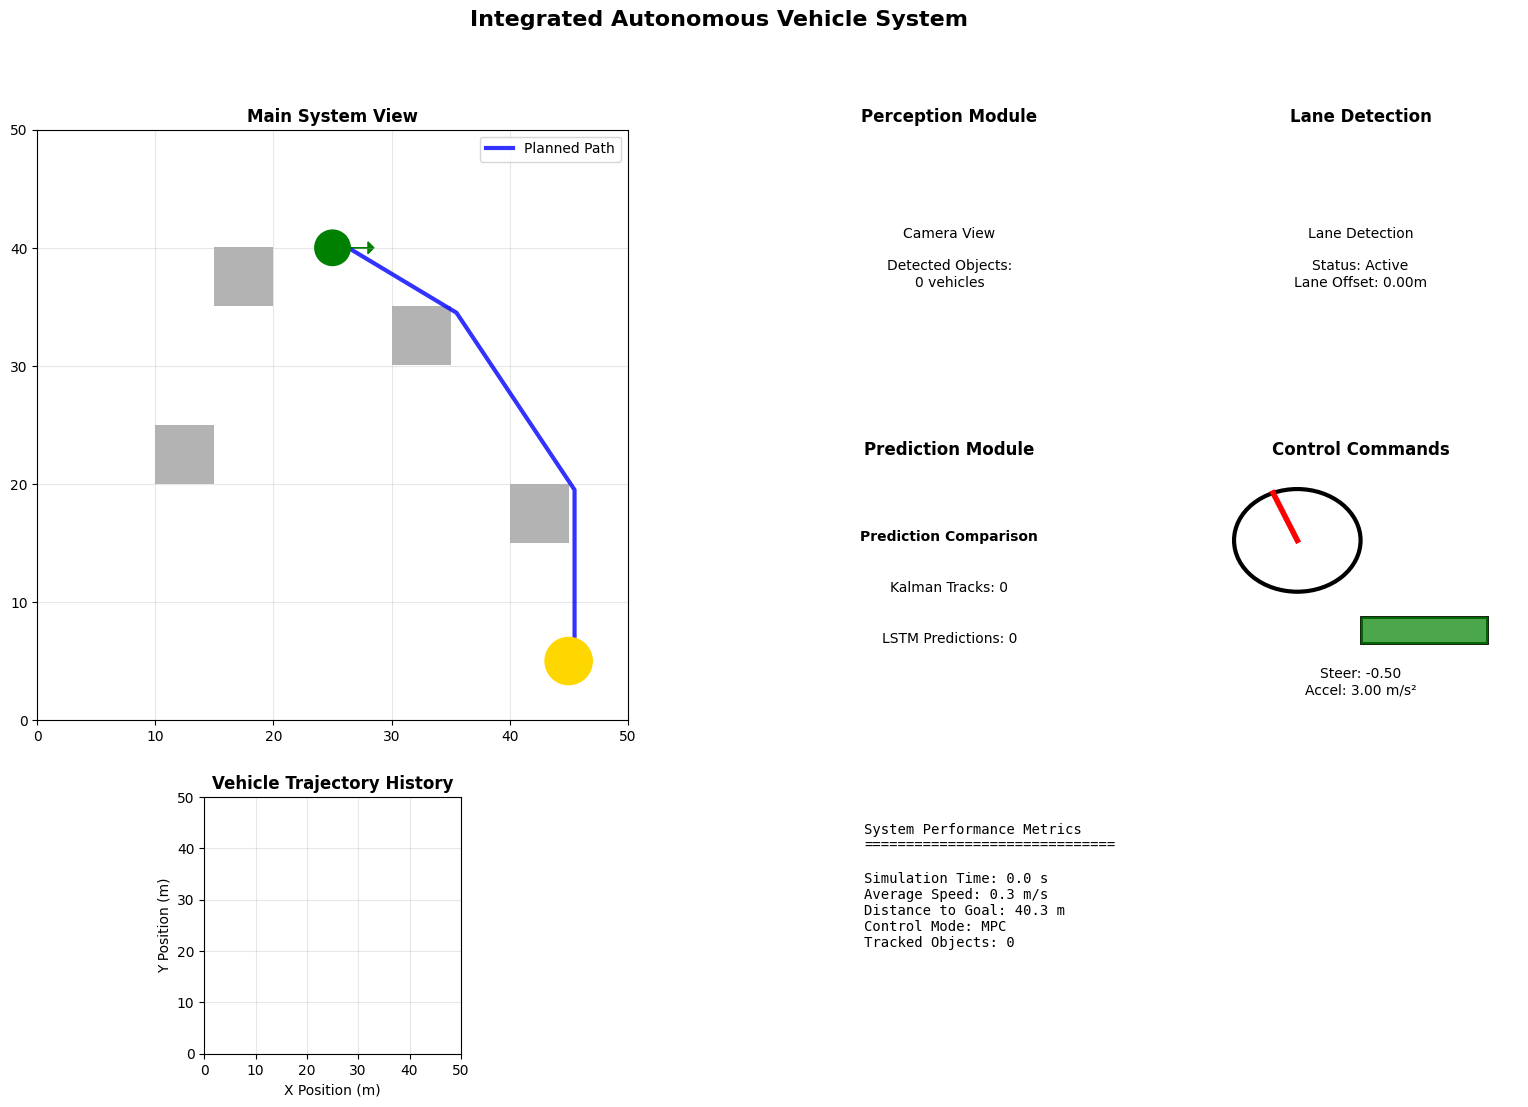


Step 2


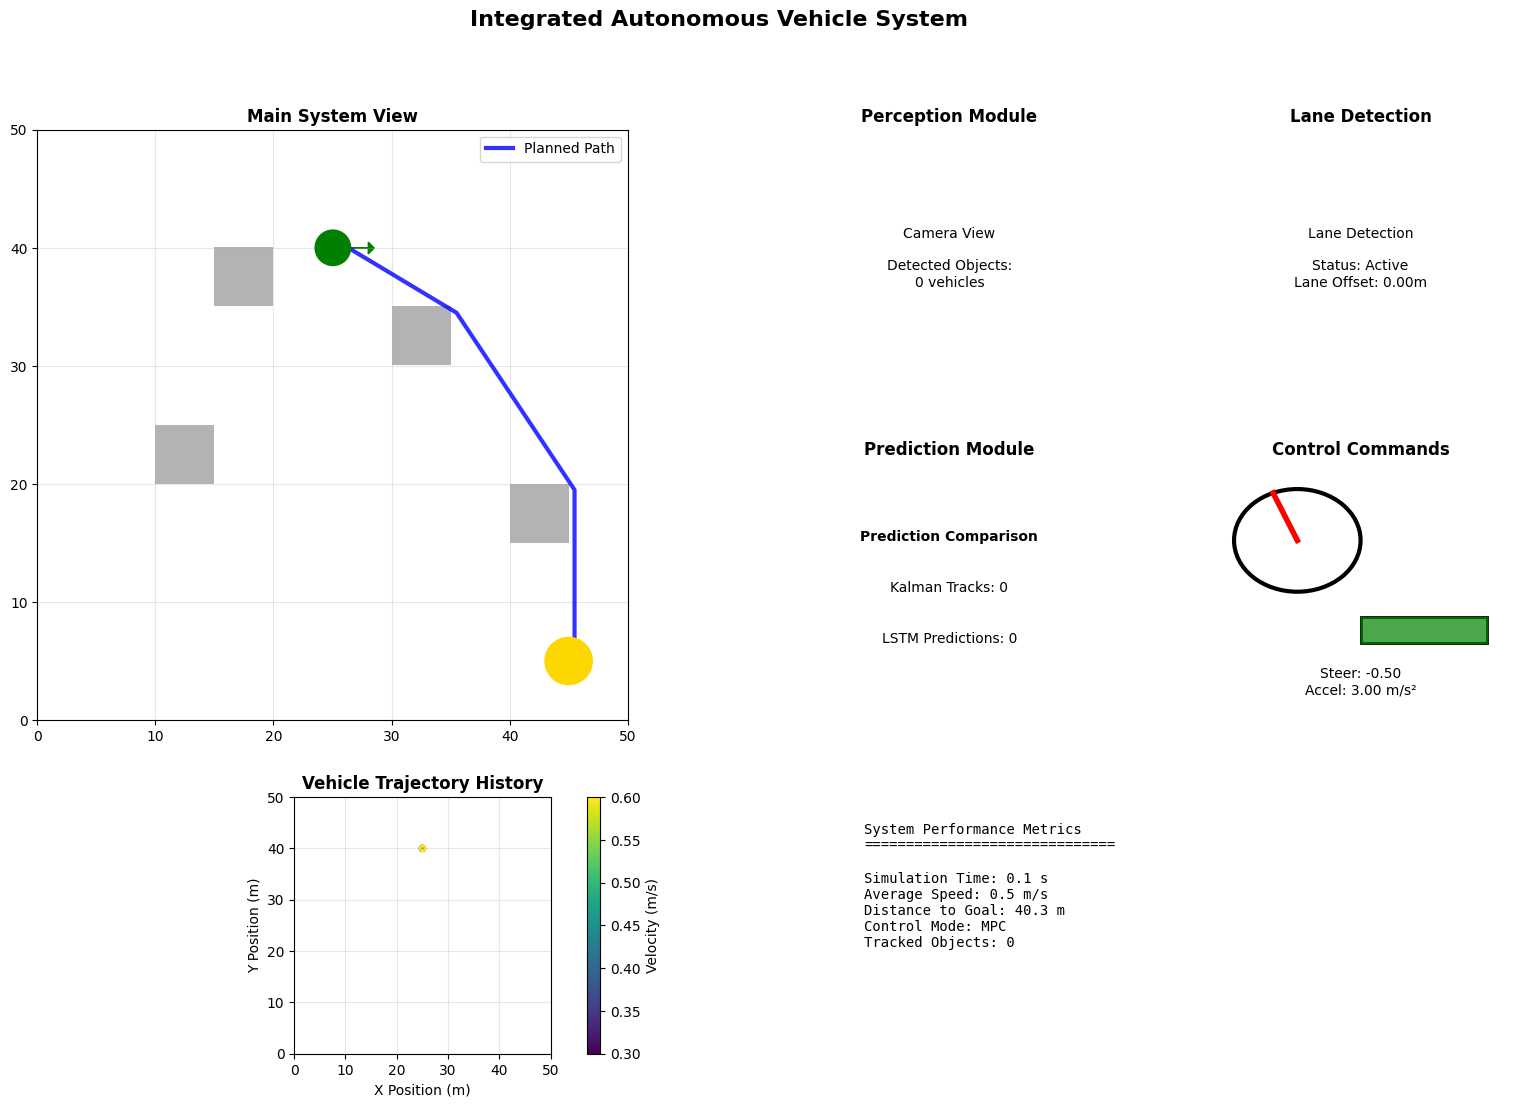


Step 3


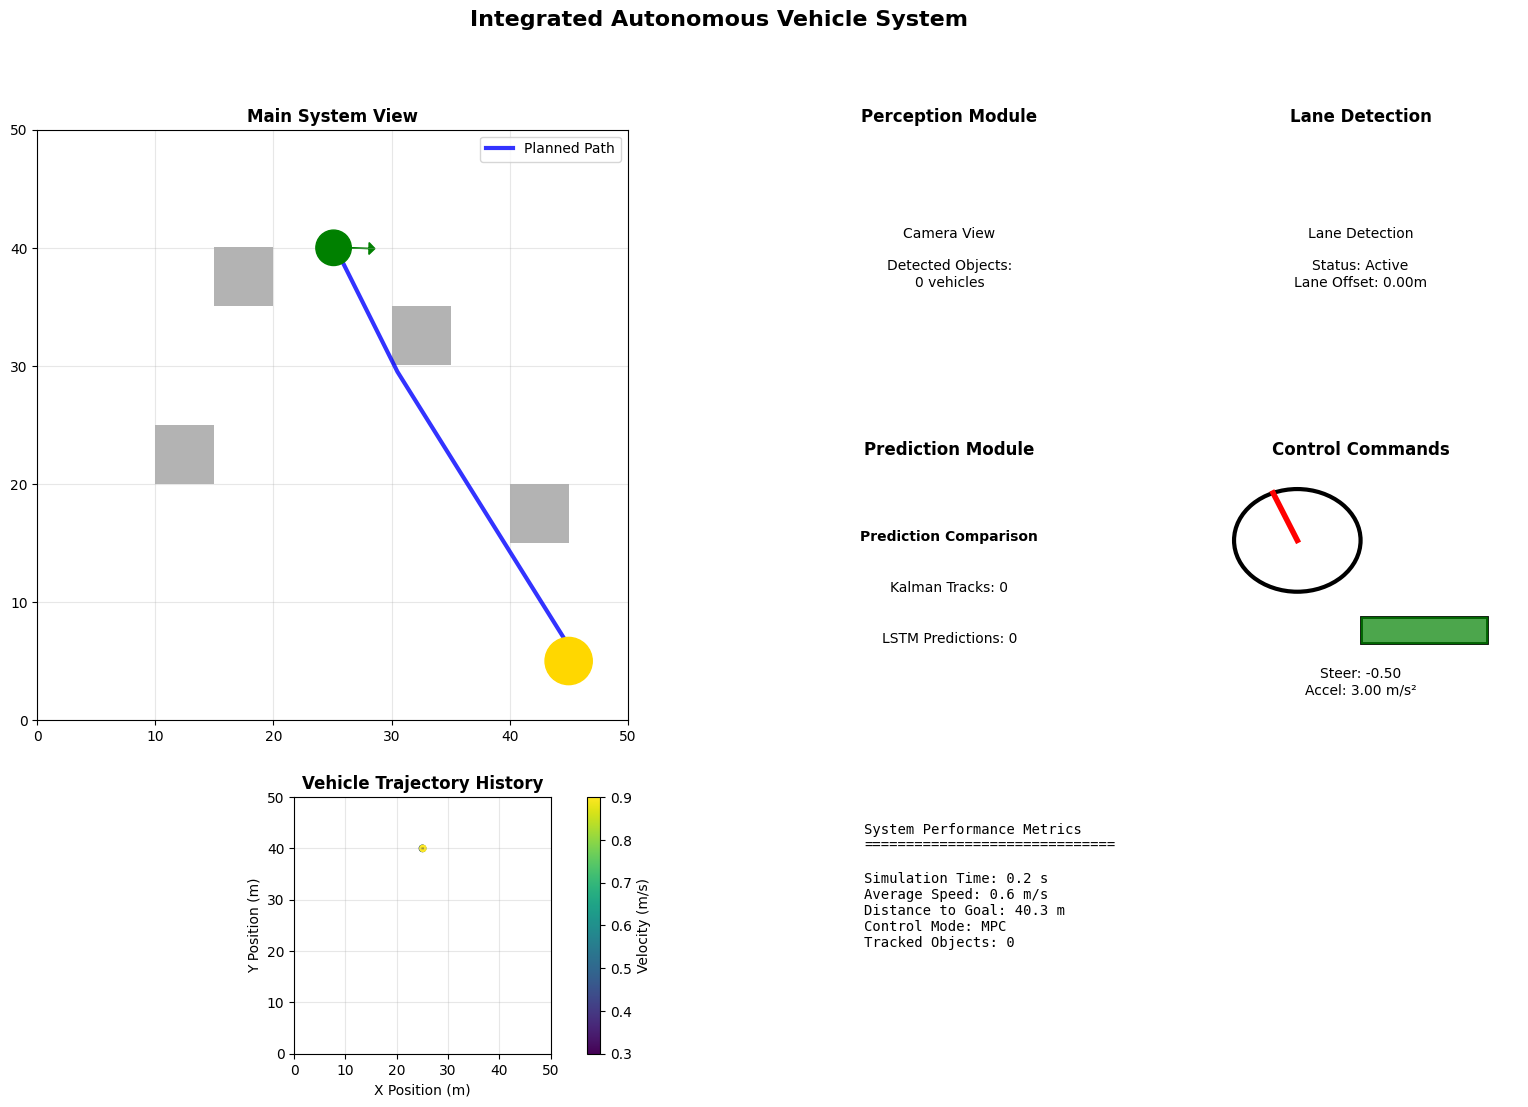


Step 4


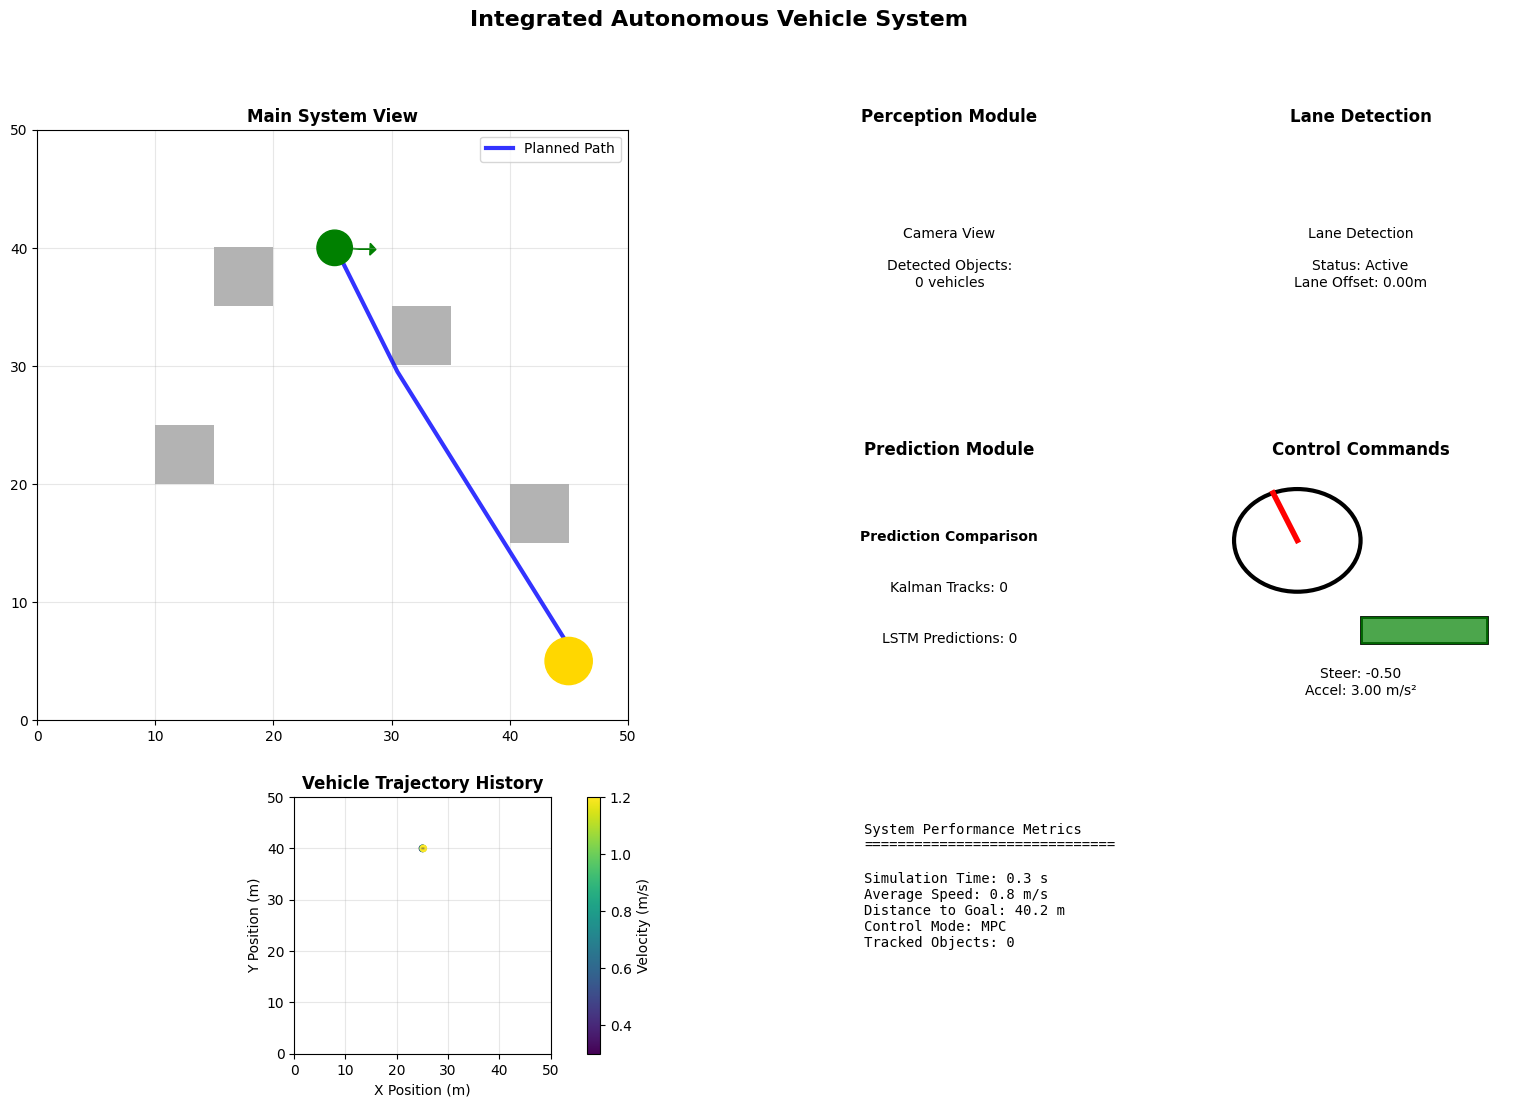


Step 5


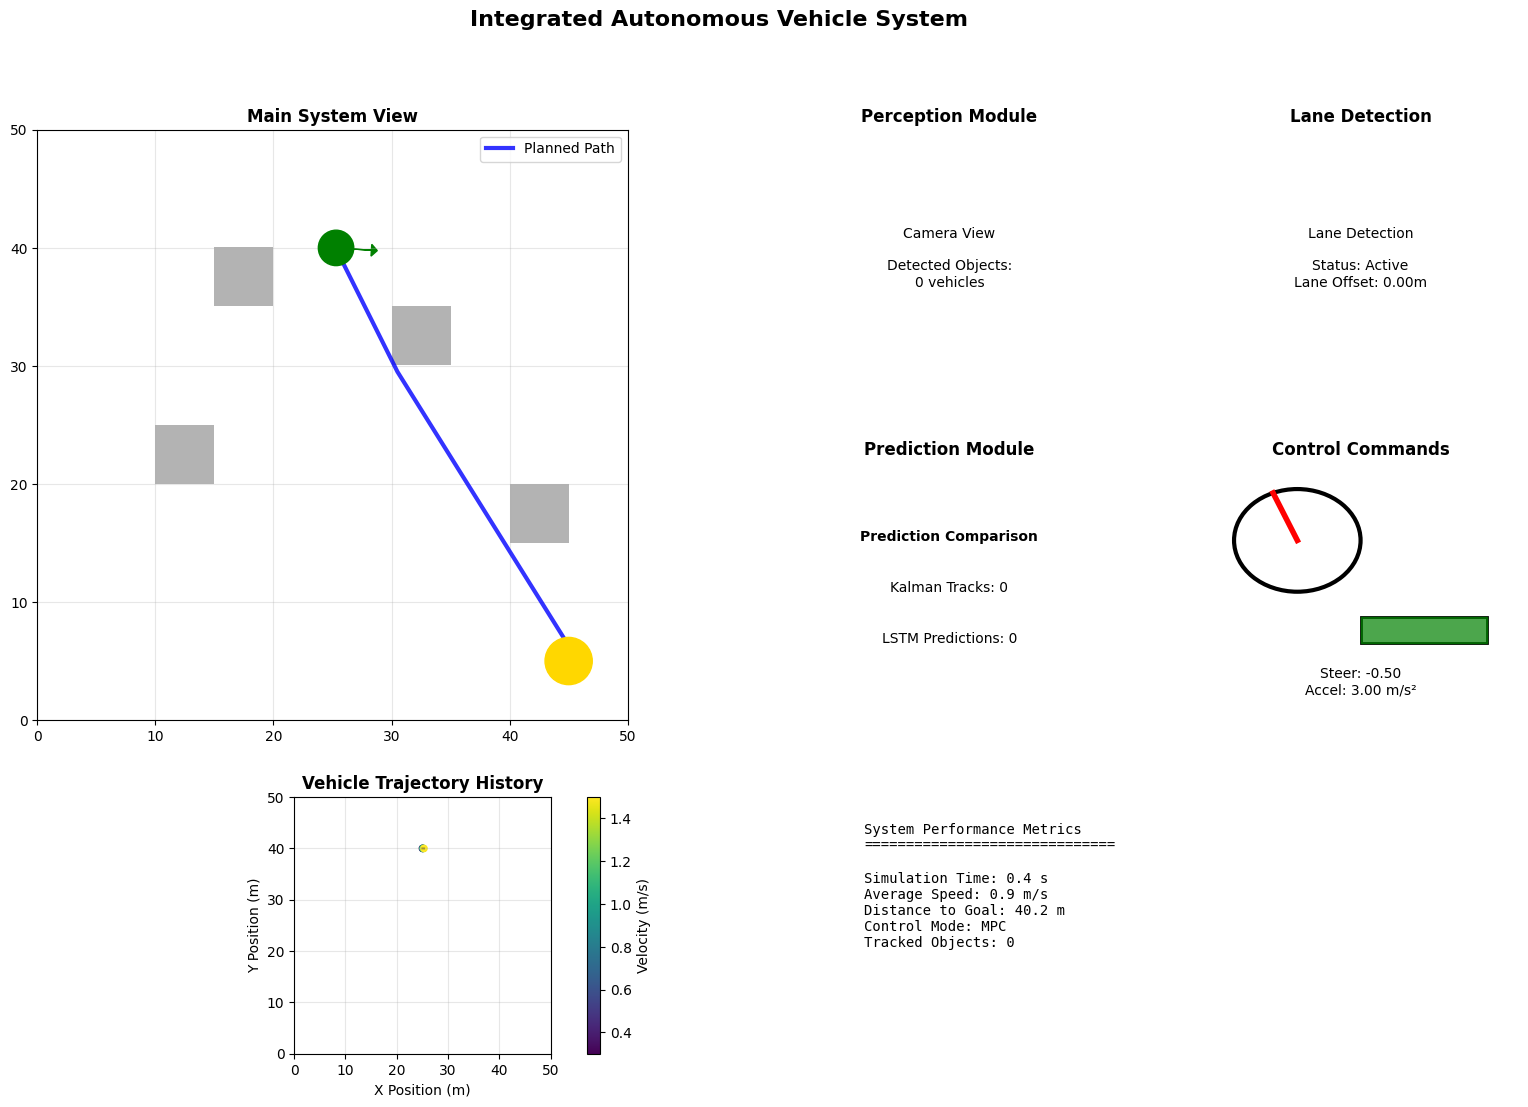


Step 6


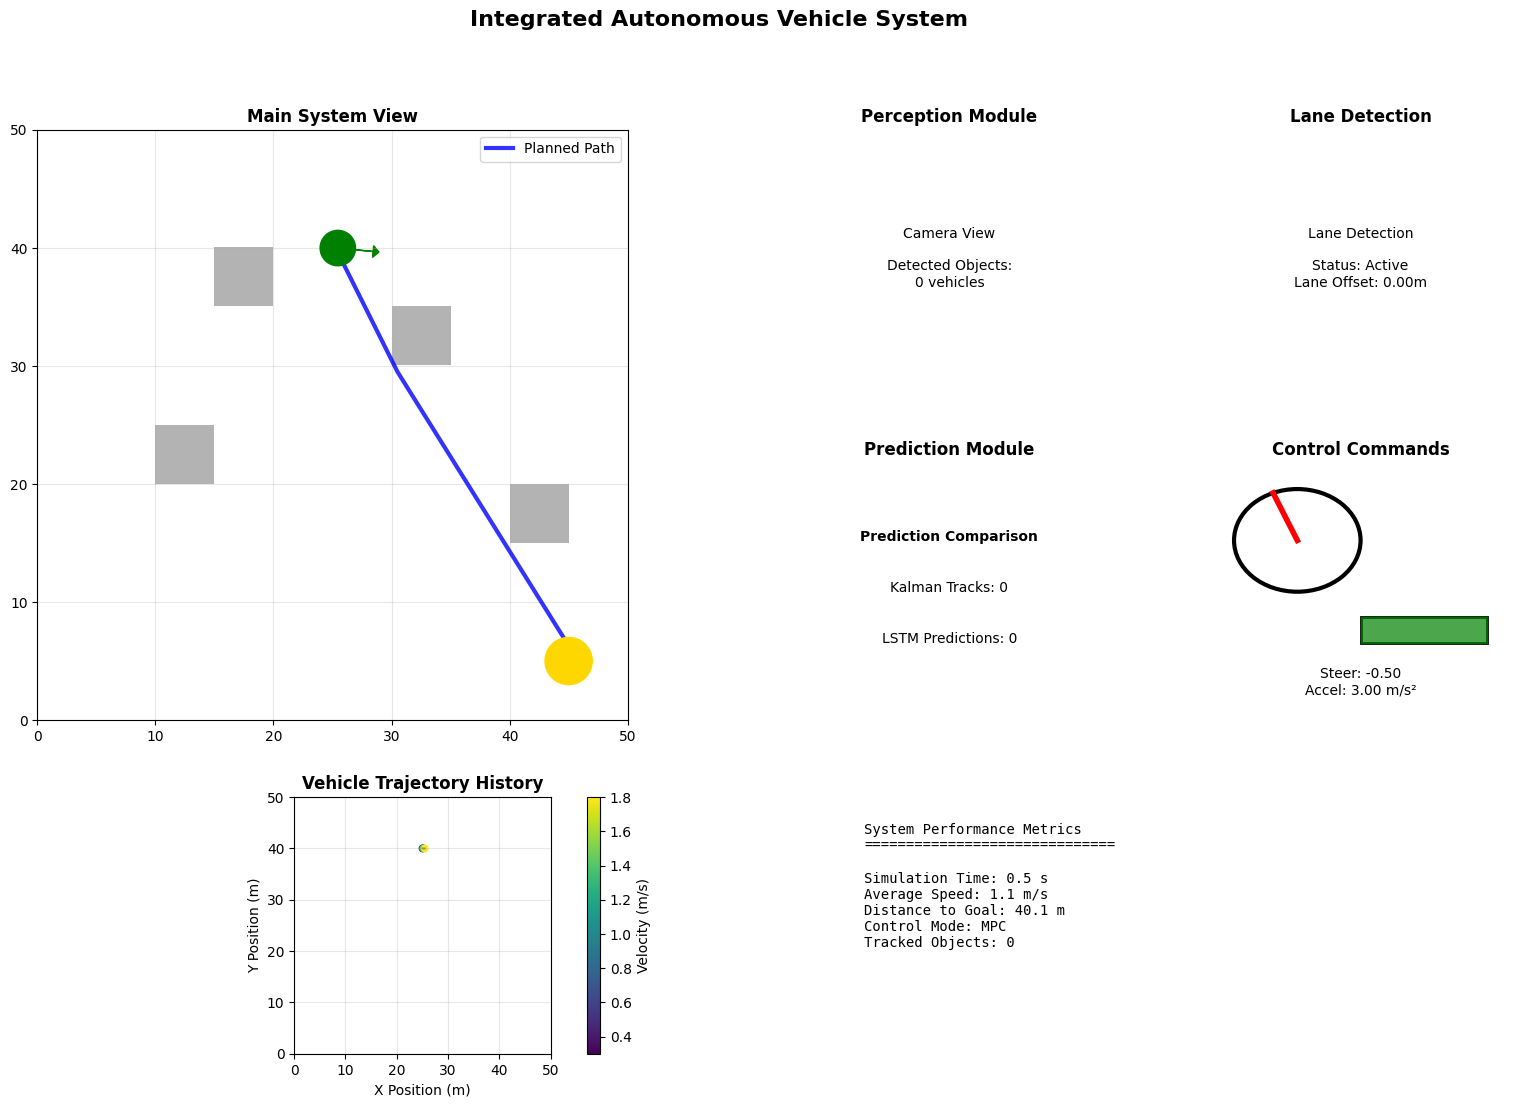


Step 7


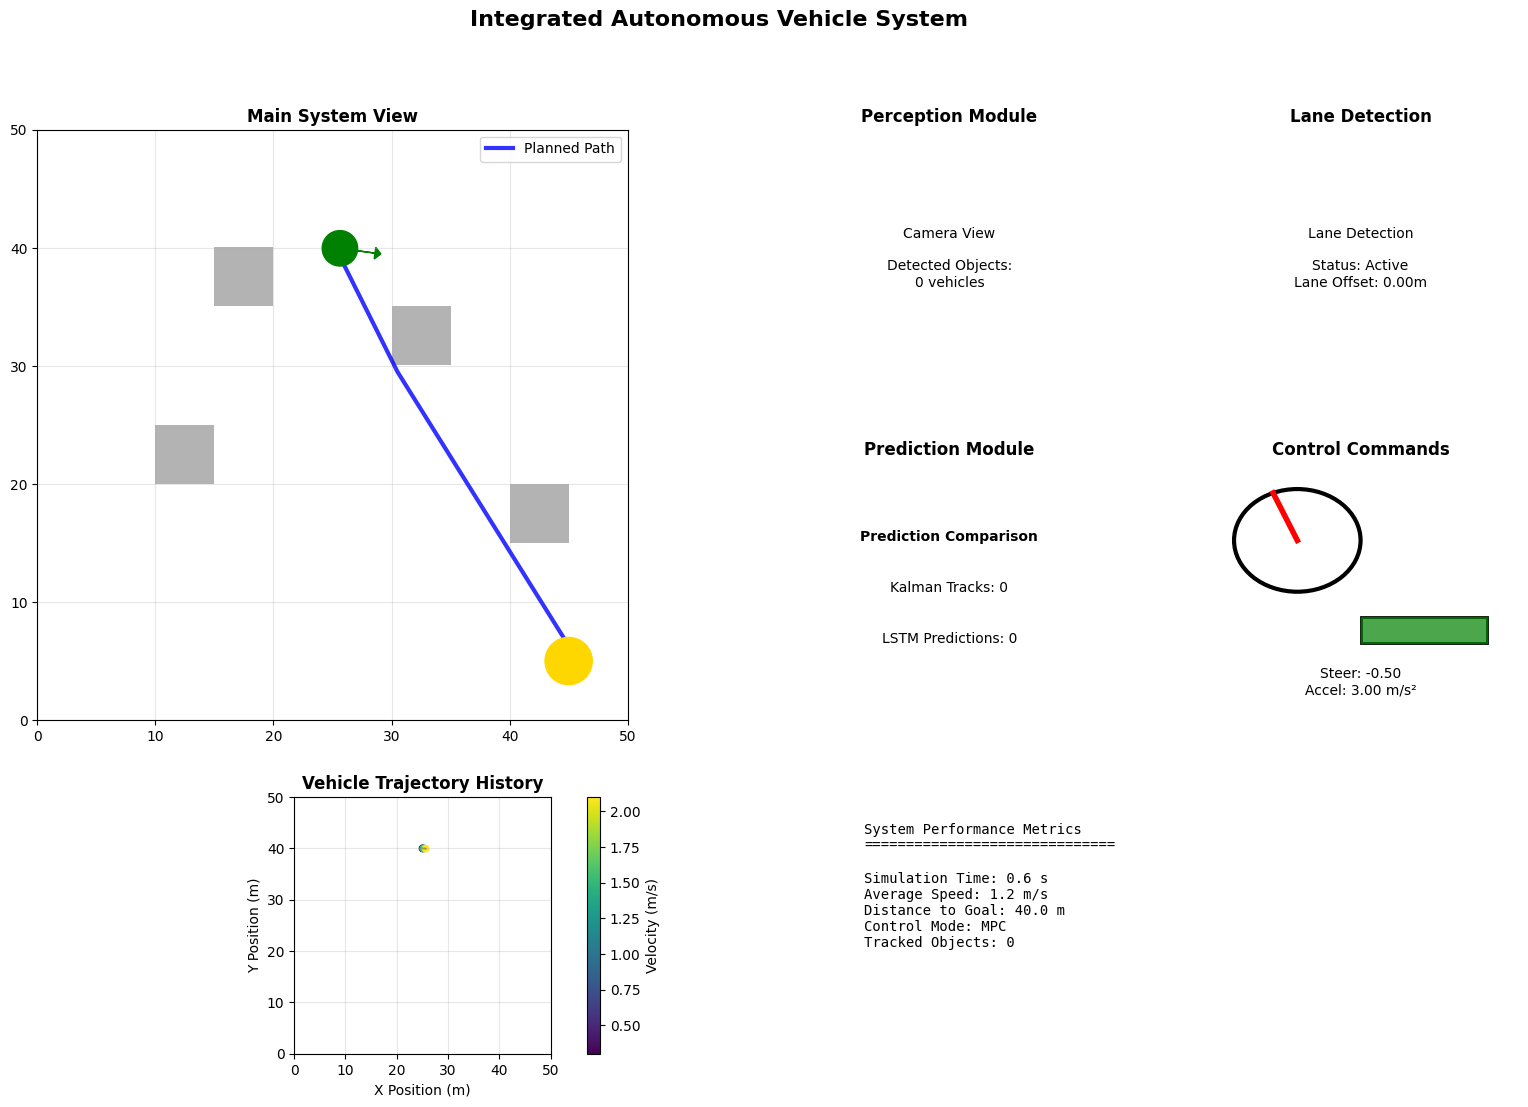


Step 8


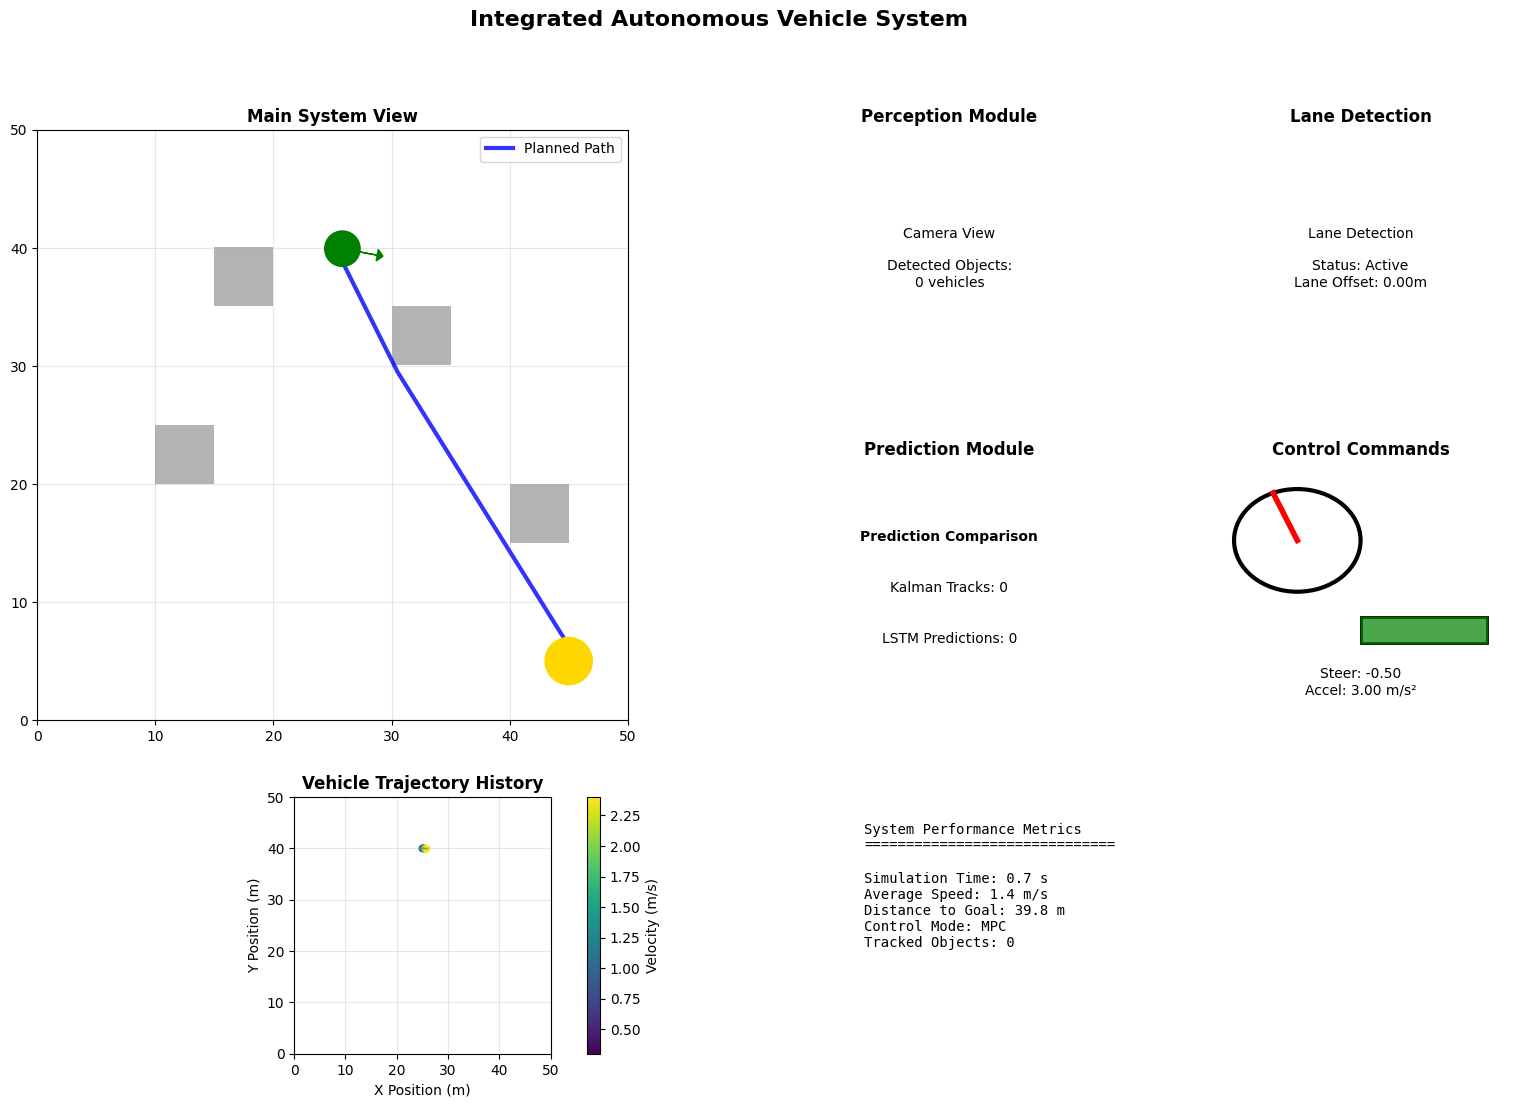


Step 9


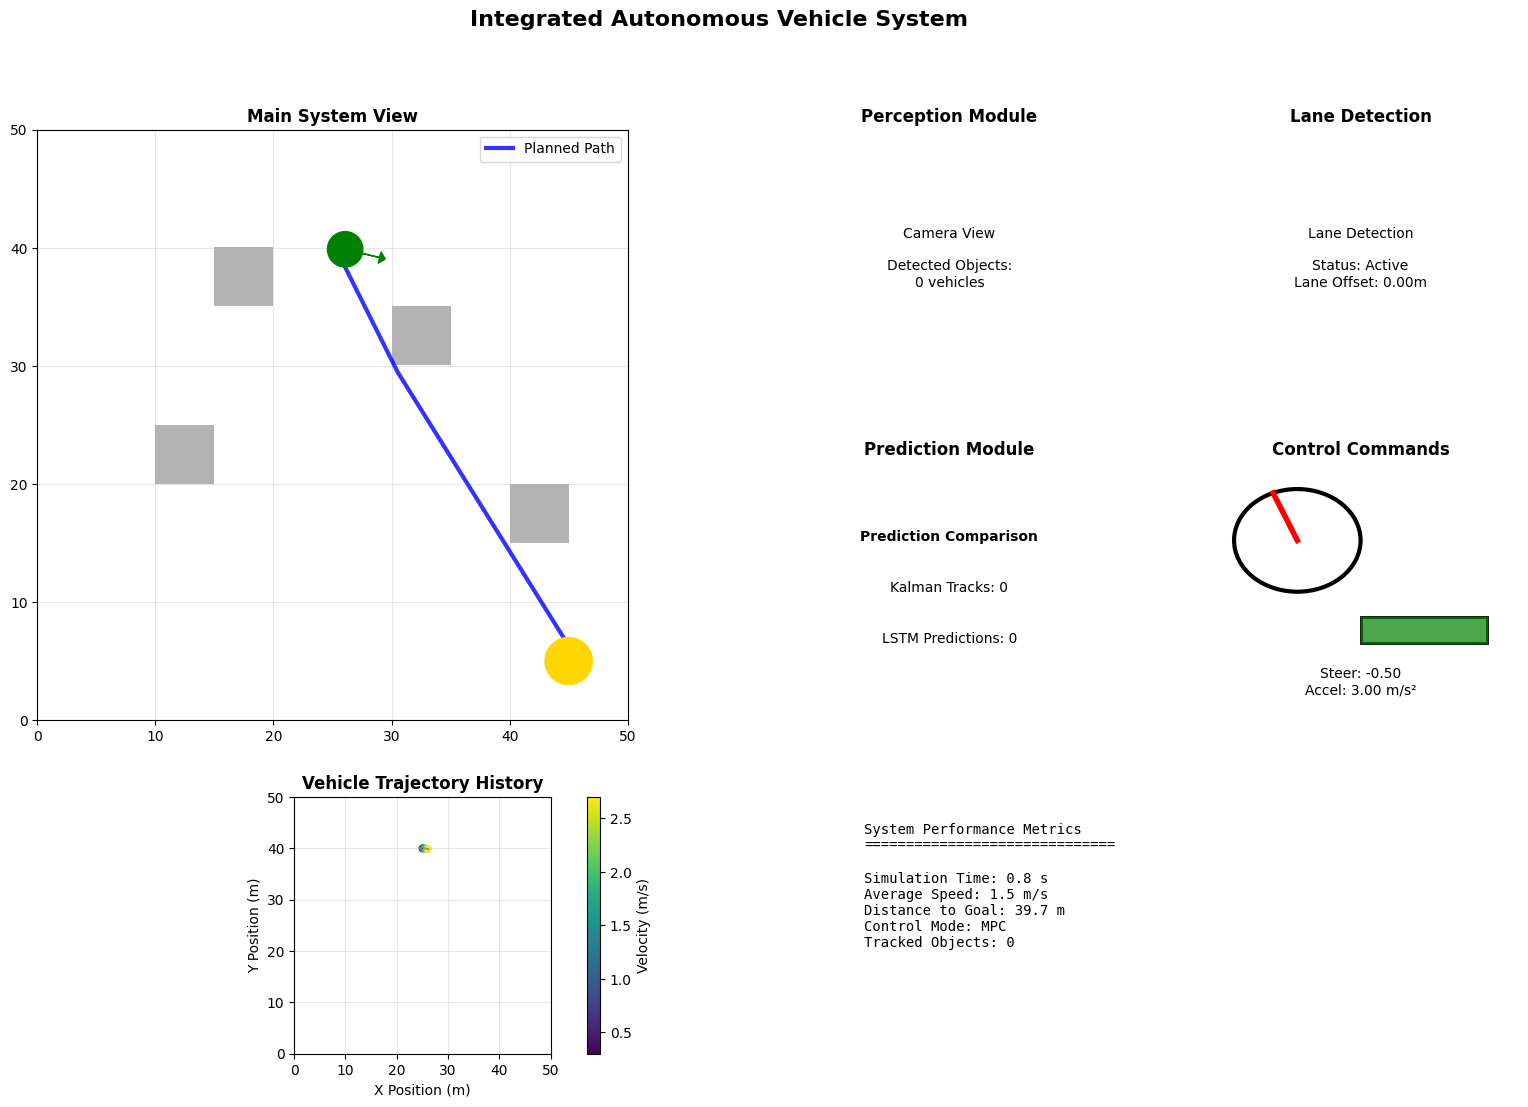


Step 10


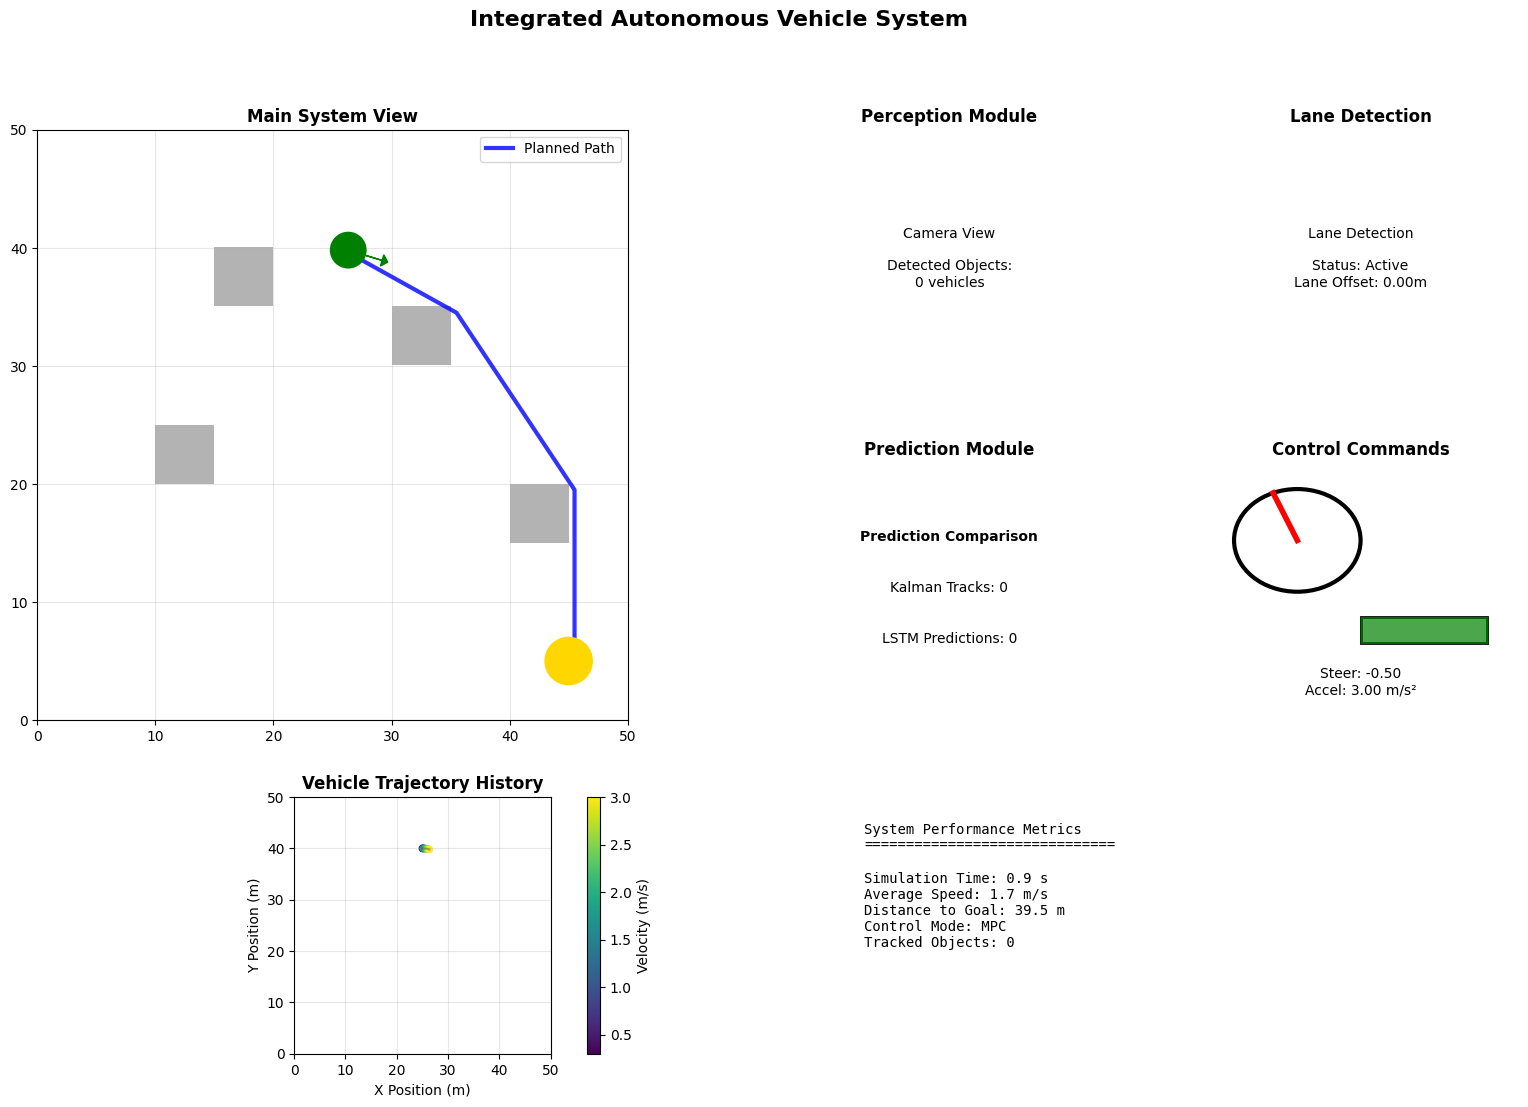


Demo complete!
Final position: [     26.331      39.802]
Final velocity: 3.0 m/s


In [18]:
# Fully Integrated Autonomous Vehicle System
# Combines all modules: Basic + Advanced features

class IntegratedAVSystem:
    """Complete AV system with perception, prediction, planning, and control"""

    def __init__(self):
        # Basic modules
        self.perception = PerceptionModule()
        self.basic_prediction = PredictionModule()
        self.planning = PlanningModule()

        # Advanced modules
        self.lane_detector = AdvancedLaneDetector()
        self.lstm_predictor = LSTMPredictor()
        self.mpc_controller = ModelPredictiveController()

        # System state
        self.vehicle_state = {
            'position': np.array([25.0, 40.0]),
            'heading': 0.0,
            'velocity': 0.0,
            'lane_offset': 0.0
        }

        # Mission parameters
        self.goal_position = np.array([45.0, 5.0])
        self.use_advanced_control = True

        # Tracking history
        self.trajectory_history = []
        self.object_tracks = {}

    def process_sensor_data(self, camera_frame=None, lidar_points=None):
        """Process all sensor inputs"""
        perception_output = {}

        if camera_frame is not None:
            # Object detection
            detections = self.perception.detect_objects(camera_frame)
            perception_output['detections'] = detections

            # Lane detection (both basic and advanced)
            basic_lanes = self.perception.detect_lanes(camera_frame)
            advanced_lanes, warped, Minv = self.lane_detector.detect_lanes_advanced(camera_frame)

            perception_output['lanes'] = {
                'basic': basic_lanes,
                'advanced': advanced_lanes,
                'transform': Minv
            }

        # Create occupancy grid from all detections
        if camera_frame is not None:
            occupancy_grid = create_occupancy_grid(detections, camera_frame.shape)
        else:
            # Use simulated grid
            occupancy_grid = self.create_simulated_occupancy_grid()

        perception_output['occupancy_grid'] = occupancy_grid

        return perception_output

    def predict_future_states(self, perception_output):
        """Predict future states of all dynamic objects"""
        predictions = {}

        # Update trackers with new detections
        if 'detections' in perception_output:
            self.basic_prediction.update_trackers(perception_output['detections'])

        # Get basic Kalman predictions
        kalman_predictions = self.basic_prediction.predict_positions()

        # Enhanced LSTM predictions for established tracks
        lstm_predictions = {}
        for track_id, tracker in self.basic_prediction.trackers.items():
            if track_id not in self.object_tracks:
                self.object_tracks[track_id] = []

            # Store position history
            self.object_tracks[track_id].append(tracker['kf'].x[:2].copy())

            # Use LSTM if enough history
            if len(self.object_tracks[track_id]) >= 5:
                history = np.array(self.object_tracks[track_id][-10:])
                lstm_pred = self.lstm_predictor.predict_trajectory(history)
                lstm_predictions[track_id] = lstm_pred

        predictions['kalman'] = kalman_predictions
        predictions['lstm'] = lstm_predictions

        return predictions

    def plan_trajectory(self, perception_output, predictions):
        """Plan vehicle trajectory considering all information"""
        # Get current grid position
        current_grid_pos = (int(self.vehicle_state['position'][0]),
                           int(self.vehicle_state['position'][1]))
        goal_grid_pos = (int(self.goal_position[0]), int(self.goal_position[1]))

        # Create dynamic occupancy grid considering predictions
        dynamic_grid = perception_output['occupancy_grid'].copy()

        # Add predicted positions to grid (collision avoidance)
        for track_id, pred_positions in predictions['lstm'].items():
            for i, pos in enumerate(pred_positions[:5]):  # Next 5 timesteps
                x, y = int(pos[0]), int(pos[1])
                if 0 <= x < 50 and 0 <= y < 50:
                    # Increase cost for predicted positions
                    dynamic_grid[y, x] = min(1.0, dynamic_grid[y, x] + 0.3)

        # Plan path with A*
        path = self.planning.a_star(current_grid_pos, goal_grid_pos, dynamic_grid)

        if path:
            # Smooth the path
            smoothed_path = self.planning.smooth_path(path, dynamic_grid)

            # Convert to continuous coordinates
            continuous_path = []
            for point in smoothed_path:
                continuous_path.append([
                    point[0] + 0.5,  # Center of grid cell
                    point[1] + 0.5,
                    self.calculate_desired_heading(point, smoothed_path),
                    10.0  # Desired speed
                ])

            return np.array(continuous_path)

        return None

    def calculate_desired_heading(self, current_point, path):
        """Calculate desired heading angle for a path point"""
        idx = path.index(current_point)
        if idx < len(path) - 1:
            next_point = path[idx + 1]
            dx = next_point[0] - current_point[0]
            dy = next_point[1] - current_point[1]
            return np.arctan2(dy, dx)
        return self.vehicle_state['heading']

    def execute_control(self, planned_trajectory, dt=0.1):
        """Execute control using either PID or MPC"""
        if planned_trajectory is None or len(planned_trajectory) == 0:
            return 0, 0  # Stop if no path

        if self.use_advanced_control:
            # Use Model Predictive Control
            state = np.array([
                self.vehicle_state['position'][0],
                self.vehicle_state['position'][1],
                self.vehicle_state['heading'],
                self.vehicle_state['velocity']
            ])

            steer, accel = self.mpc_controller.solve(state, planned_trajectory)

        else:
            # Use basic PID control
            target = planned_trajectory[min(5, len(planned_trajectory)-1)][:2]
            control = ControlModule()
            steer, throttle = control.compute_control(
                self.vehicle_state['position'],
                target,
                self.vehicle_state['heading']
            )
            accel = (throttle * 10.0 - self.vehicle_state['velocity']) * 2.0

        # Update vehicle state
        self.update_vehicle_state(steer, accel, dt)

        return steer, accel

    def update_vehicle_state(self, steer, accel, dt):
        """Update vehicle state using bicycle model"""
        # Current state
        x, y = self.vehicle_state['position']
        theta = self.vehicle_state['heading']
        v = self.vehicle_state['velocity']

        # Update velocity
        v_new = v + accel * dt
        v_new = np.clip(v_new, 0, 20)  # Max 20 m/s

        # Update position (bicycle model)
        if abs(steer) > 0.001:
            # Turning radius
            R = self.mpc_controller.L / np.tan(steer)
            # Angular velocity
            omega = v / R

            # Update heading
            theta_new = theta + omega * dt

            # Update position
            x_new = x + R * (np.sin(theta_new) - np.sin(theta))
            y_new = y - R * (np.cos(theta_new) - np.cos(theta))
        else:
            # Straight line
            theta_new = theta
            x_new = x + v * np.cos(theta) * dt
            y_new = y + v * np.sin(theta) * dt

        # Update state
        self.vehicle_state['position'] = np.array([x_new, y_new])
        self.vehicle_state['heading'] = theta_new
        self.vehicle_state['velocity'] = v_new

        # Store in history
        self.trajectory_history.append({
            'position': self.vehicle_state['position'].copy(),
            'heading': self.vehicle_state['heading'],
            'velocity': self.vehicle_state['velocity'],
            'time': len(self.trajectory_history) * dt
        })

    def create_simulated_occupancy_grid(self):
        """Create a simulated environment for testing"""
        grid = np.zeros((50, 50))

        # Add some obstacles
        obstacles = [
            (10, 20, 5, 5),
            (30, 30, 5, 5),
            (40, 15, 5, 5),
            (15, 35, 5, 5),
        ]

        for x, y, w, h in obstacles:
            grid[y:y+h, x:x+w] = 1

        return grid

    def visualize_complete_system(self, perception_output, predictions, trajectory, control):
        """Create comprehensive system visualization"""
        fig = plt.figure(figsize=(20, 12))

        # Create grid layout
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

        # 1. Main system view (large)
        ax_main = fig.add_subplot(gs[0:2, 0:2])
        self.plot_main_view(ax_main, perception_output, predictions, trajectory)

        # 2. Camera view with detections
        ax_camera = fig.add_subplot(gs[0, 2])
        self.plot_camera_view(ax_camera, perception_output)

        # 3. Lane detection view
        ax_lanes = fig.add_subplot(gs[0, 3])
        self.plot_lane_view(ax_lanes, perception_output)

        # 4. Prediction comparison
        ax_pred = fig.add_subplot(gs[1, 2])
        self.plot_predictions(ax_pred, predictions)

        # 5. Control signals
        ax_control = fig.add_subplot(gs[1, 3])
        self.plot_control(ax_control, control)

        # 6. Vehicle trajectory history
        ax_history = fig.add_subplot(gs[2, 0:2])
        self.plot_trajectory_history(ax_history)

        # 7. System metrics
        ax_metrics = fig.add_subplot(gs[2, 2:4])
        self.plot_system_metrics(ax_metrics)

        plt.suptitle('Integrated Autonomous Vehicle System', fontsize=16, fontweight='bold')

        return fig

    def plot_main_view(self, ax, perception_output, predictions, trajectory):
        """Plot main system overview"""
        # Occupancy grid
        ax.imshow(perception_output['occupancy_grid'], cmap='gray_r',
                 alpha=0.3, extent=[0, 50, 0, 50], origin='lower')

        # Planned trajectory
        if trajectory is not None:
            ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=3,
                   label='Planned Path', alpha=0.8)

        # Vehicle
        vehicle_pos = self.vehicle_state['position']
        vehicle_marker = plt.Circle(vehicle_pos, 1.5, color='green', zorder=10)
        ax.add_patch(vehicle_marker)

        # Vehicle heading arrow
        arrow_len = 3
        dx = arrow_len * np.cos(self.vehicle_state['heading'])
        dy = arrow_len * np.sin(self.vehicle_state['heading'])
        ax.arrow(vehicle_pos[0], vehicle_pos[1], dx, dy,
                head_width=1, head_length=0.5, fc='green', ec='green')

        # Goal
        goal_marker = plt.Circle(self.goal_position, 2, color='gold', zorder=10)
        ax.add_patch(goal_marker)

        # Predictions
        for track_id, pred in predictions['lstm'].items():
            if len(pred) > 0:
                ax.plot(pred[:, 0], pred[:, 1], 'r--', alpha=0.5, linewidth=2)

        ax.set_xlim(0, 50)
        ax.set_ylim(0, 50)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_title('Main System View', fontweight='bold')

    def plot_camera_view(self, ax, perception_output):
        """Plot camera/perception view"""
        # Simulate camera view
        ax.text(0.5, 0.5, 'Camera View\n\nDetected Objects:\n' +
                f"{len(perception_output.get('detections', []))} vehicles",
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Perception Module', fontweight='bold')
        ax.axis('off')

    def plot_lane_view(self, ax, perception_output):
        """Plot lane detection results"""
        ax.text(0.5, 0.5, 'Lane Detection\n\nStatus: Active\nLane Offset: ' +
                f"{self.vehicle_state['lane_offset']:.2f}m",
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Lane Detection', fontweight='bold')
        ax.axis('off')

    def plot_predictions(self, ax, predictions):
        """Compare prediction methods"""
        ax.text(0.5, 0.7, 'Prediction Comparison', fontweight='bold',
                ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.5, f"Kalman Tracks: {len(predictions['kalman'])}",
                ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.3, f"LSTM Predictions: {len(predictions['lstm'])}",
                ha='center', transform=ax.transAxes)
        ax.set_title('Prediction Module', fontweight='bold')
        ax.axis('off')

    def plot_control(self, ax, control):
        """Plot control signals"""
        steer, accel = control

        # Steering visualization
        ax.add_patch(plt.Circle((0.3, 0.7), 0.2, fill=False, linewidth=3))
        steer_angle = steer * np.pi/4
        ax.plot([0.3, 0.3 + 0.2*np.sin(steer_angle)],
                [0.7, 0.7 + 0.2*np.cos(steer_angle)], 'r-', linewidth=4)

        # Throttle/brake bar
        ax.add_patch(plt.Rectangle((0.5, 0.3), 0.4, 0.1,
                                  fill=False, linewidth=2))
        if accel > 0:
            ax.add_patch(plt.Rectangle((0.5, 0.3), 0.4 * min(1, accel/3), 0.1,
                                      color='green', alpha=0.7))
        else:
            ax.add_patch(plt.Rectangle((0.5, 0.3), 0.4 * min(1, -accel/3), 0.1,
                                      color='red', alpha=0.7))

        ax.text(0.5, 0.1, f'Steer: {steer:.2f}\nAccel: {accel:.2f} m/s²',
                ha='center', transform=ax.transAxes)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title('Control Commands', fontweight='bold')
        ax.axis('off')

    def plot_trajectory_history(self, ax):
        """Plot vehicle trajectory history"""
        if len(self.trajectory_history) > 1:
            positions = [h['position'] for h in self.trajectory_history]
            positions = np.array(positions)

            # Color by velocity
            velocities = [h['velocity'] for h in self.trajectory_history]

            scatter = ax.scatter(positions[:, 0], positions[:, 1],
                               c=velocities, cmap='viridis', s=20)
            ax.plot(positions[:, 0], positions[:, 1], 'k-', alpha=0.3)

            # Colorbar
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Velocity (m/s)')

        ax.set_xlim(0, 50)
        ax.set_ylim(0, 50)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title('Vehicle Trajectory History', fontweight='bold')
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')

    def plot_system_metrics(self, ax):
        """Display system performance metrics"""
        metrics_text = "System Performance Metrics\n" + "="*30 + "\n\n"

        # Calculate metrics
        if len(self.trajectory_history) > 0:
            current_time = self.trajectory_history[-1]['time']
            avg_velocity = np.mean([h['velocity'] for h in self.trajectory_history[-10:]])
            distance_to_goal = np.linalg.norm(self.vehicle_state['position'] - self.goal_position)

            metrics_text += f"Simulation Time: {current_time:.1f} s\n"
            metrics_text += f"Average Speed: {avg_velocity:.1f} m/s\n"
            metrics_text += f"Distance to Goal: {distance_to_goal:.1f} m\n"
            metrics_text += f"Control Mode: {'MPC' if self.use_advanced_control else 'PID'}\n"
            metrics_text += f"Tracked Objects: {len(self.object_tracks)}\n"

        ax.text(0.1, 0.9, metrics_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')
        ax.axis('off')

    def run_step(self, camera_frame=None, dt=0.1):
        """Run one complete cycle of the AV system"""
        # 1. Perception
        perception_output = self.process_sensor_data(camera_frame)

        # 2. Prediction
        predictions = self.predict_future_states(perception_output)

        # 3. Planning
        trajectory = self.plan_trajectory(perception_output, predictions)

        # 4. Control
        steer, accel = self.execute_control(trajectory, dt)

        # 5. Visualization
        fig = self.visualize_complete_system(
            perception_output, predictions, trajectory, (steer, accel)
        )

        return {
            'perception': perception_output,
            'predictions': predictions,
            'trajectory': trajectory,
            'control': (steer, accel),
            'visualization': fig
        }

# Demo the integrated system
def run_integrated_demo():
    """Run the complete integrated AV system demo"""
    print("Initializing Integrated AV System...")
    av_system = IntegratedAVSystem()

    print("Running autonomous navigation...")

    # Run for several steps
    for step in range(10):
        print(f"\nStep {step + 1}")

        # Run one cycle
        results = av_system.run_step(camera_frame=None, dt=0.1)

        # Show visualization
        plt.show()

        # Check if goal reached
        distance_to_goal = np.linalg.norm(
            av_system.vehicle_state['position'] - av_system.goal_position
        )

        if distance_to_goal < 2.0:
            print("Goal reached!")
            break

        # Small delay for visualization
        time.sleep(0.5)

    print("\nDemo complete!")
    print(f"Final position: {av_system.vehicle_state['position']}")
    print(f"Final velocity: {av_system.vehicle_state['velocity']:.1f} m/s")

# Run the demo
run_integrated_demo()

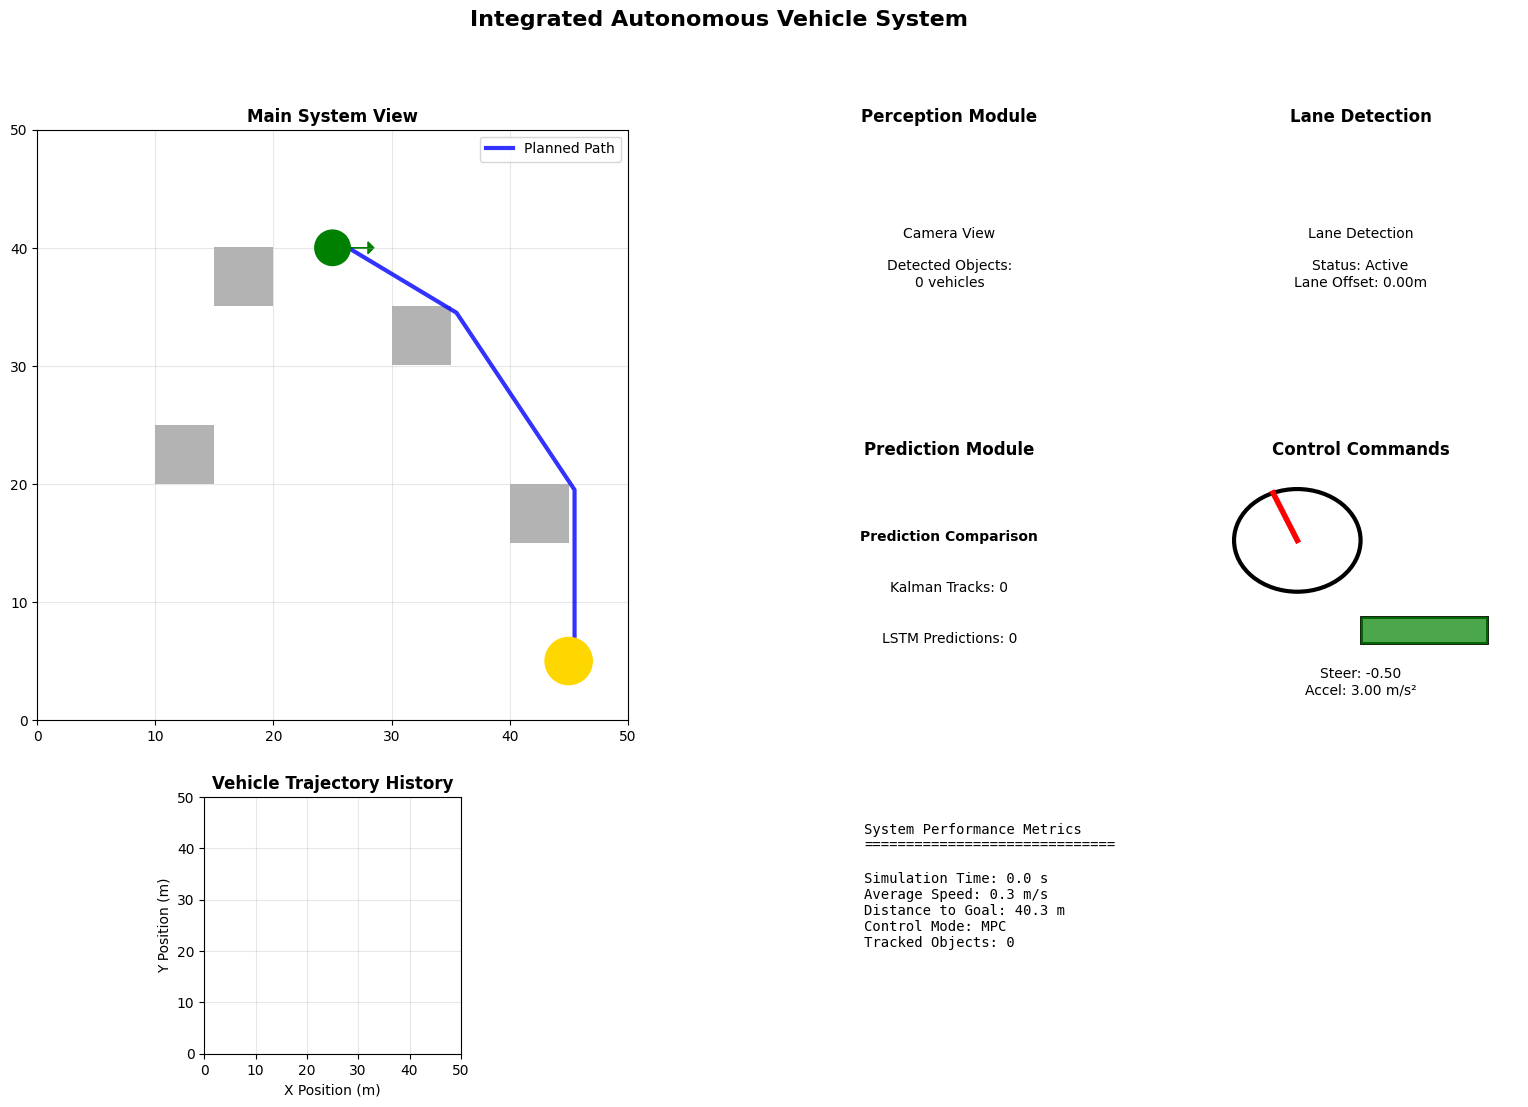

In [19]:
av_system = IntegratedAVSystem()
results = av_system.run_step()

In [1]:
# Step 1: Mount Google Drive to access the KITTI dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
